# Step 4. Model Evaluation & Metrics

### In this step, we evaluate and compare our trained models (Custom CNN and MobileNetV2) to assess whether they meet the expectations of Hypothesis 1:
> *"A convolutional neural network (CNN) can accurately classify fruit images into 8 classes."*

We perform the following evaluations:

1. **Classification Report**
   - Computes precision, recall, and F1-score for each fruit class.
   - Helps us understand how well each model predicts individual categories.

2. **Confusion Matrix**
   - A matrix showing how often classes are correctly or incorrectly predicted.
   - Reveals systematic misclassifications (e.g., between visually similar fruits).

3. **Overall Accuracy**
   - The percentage of correctly predicted images in the test set.
   - Provides a straightforward benchmark for comparing models.

4. **Learning Curves**
   - Plots of training loss and validation accuracy over epochs.
   - Allow us to compare convergence speed and detect overfitting/underfitting.

These metrics provide insight into the **strengths and weaknesses of each approach** (lightweight custom CNN vs. pretrained MobileNetV2), and allow us to determine whether the models are suitable for real-world use or require further improvement.


In [1]:
# Cell 0 — Setup: imports, device, paths, helpers
import os, sys, re, json, torch
import numpy as np

# --- make sure we can import from ../src
SRC_PATH = os.path.abspath("../src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

# --- import experiment runner (fail with a clear message if missing)
try:
    from models.mobileNetV2compare import (
        TrainConfig,
        run_mobilenet_v2_experiment,
    )
except ImportError as e:
    raise ImportError(
        "Could not import models.mobileNetV2compare. "
        "Check that ../src/models/mobileNetV2compare.py exists and is importable."
    ) from e

# --- default dataset paths (optionally overridden by config if present)
TRAIN_DIR = '../Dataset/Training'
TEST_DIR  = '../Dataset/Test'

for cfg_path in ("../configs/dataset_config.json", "configs/dataset_config.json"):
    if os.path.exists(cfg_path):
        try:
            with open(cfg_path, "r", encoding="utf-8") as f:
                _cfg = json.load(f)
            TRAIN_DIR = _cfg.get("fr360_train", TRAIN_DIR)
            TEST_DIR  = _cfg.get("fr360_test",  TEST_DIR)
        except Exception:
            pass  # keep defaults if config is unreadable
        break

# --- device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Device: {device}" + (f" ({torch.cuda.get_device_name(0)})" if device.type == "cuda" else ""))

# --- ensure result dirs
RESULTS_DIR = "../experiments/results"
PLOTS_DIR   = "../experiments/plots"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR,   exist_ok=True)

# --- tiny helpers
def slugify(s):
    s = "" if s is None else str(s)
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", s).strip("_")

# stores for later statistical tests (e.g., McNemar, ECE)
pred_store = {}  # name -> {"y_true": np.ndarray, "y_pred": np.ndarray}
prob_store = {}  # name -> np.ndarray of class probabilities

# --- sanity logs
if not os.path.isdir(TRAIN_DIR): print(f"[WARN] TRAIN_DIR not found: {TRAIN_DIR}")
if not os.path.isdir(TEST_DIR):  print(f"[WARN] TEST_DIR not found:  {TEST_DIR}")
print(f"[INFO] Results → {RESULTS_DIR}")
print(f"[INFO] Plots   → {PLOTS_DIR}")


[INFO] Device: cuda (NVIDIA GeForce RTX 4060)
[INFO] Results → ../experiments/results
[INFO] Plots   → ../experiments/plots


In [2]:
# Cell 0b — Populate pred_store from disk (CNN JSON + MobileNetV2 checkpoints)
import os, json, re, numpy as np, torch

# make sure stores exist (in case Cell 0 wasn't run)
if 'pred_store' not in globals(): pred_store = {}
if 'prob_store' not in globals(): prob_store = {}

# device + paths (fallbacks if not in globals)
device    = globals().get('device', torch.device("cuda" if torch.cuda.is_available() else "cpu"))
TRAIN_DIR = globals().get('TRAIN_DIR', '../Dataset/Training')
TEST_DIR  = globals().get('TEST_DIR',  '../Dataset/Test')

def slugify(s): 
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", str(s) if s is not None else "").strip("_")

# ---------------------------
# 1) Load Custom CNN predictions saved in Step 3 JSON
# ---------------------------
cnn_json_path = "../experiments/results/custom_cnn_results.json"
if os.path.exists(cnn_json_path):
    with open(cnn_json_path, "r", encoding="utf-8") as f:
        cnn_data = json.load(f)

    loaded = 0
    for name, d in cnn_data.items():
        yt = d.get("y_true"); yp = d.get("y_pred")
        if yt is None or yp is None:
            continue
        pred_store[name] = {
            "y_true": np.asarray(yt),
            "y_pred": np.asarray(yp),
            "class_names": d.get("class_names", None),
        }
        if "y_prob" in d and d["y_prob"] is not None:
            prob_store[name] = np.asarray(d["y_prob"])
        loaded += 1
    print(f"[INFO] Loaded Custom CNN preds for {loaded} model(s) from JSON.")
else:
    print("[INFO] custom_cnn_results.json not found; skipping CNN load.")

# ---------------------------
# 2) Recreate MobileNetV2 predictions from checkpoints
# ---------------------------
try:
    from models.mobileNetV2compare import prepare_mobilenet_v2, get_mobilenet_loaders
except ImportError as e:
    print(f"[WARN] Could not import MobileNetV2 utilities: {e}")
    prepare_mobilenet_v2 = None
    get_mobilenet_loaders = None

mnv2_specs = {
    "MobileNetV2 Grayscale MaxPool":  {"ckpt":"../experiments/runs/mnv2_gray_max.pt",   "input_type":"grayscale", "pooling":"max"},
    "MobileNetV2 Grayscale Adaptive": {"ckpt":"../experiments/runs/mnv2_gray_adapt.pt", "input_type":"grayscale", "pooling":"adaptive"},
    "MobileNetV2 RGB With Noise":     {"ckpt":"../experiments/runs/mnv2_rgb_noise.pt",  "input_type":"rgb",       "pooling":"default", "use_noise": True},
    "MobileNetV2 RGB Clean":          {"ckpt":"../experiments/runs/mnv2_rgb_clean.pt",  "input_type":"rgb",       "pooling":"default", "use_noise": False},
}

@torch.no_grad()
def _infer_preds(model, loader, device):
    model.eval().to(device)
    ys, yhat = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        ys.append((yb if torch.is_tensor(yb) else torch.as_tensor(yb)).cpu().numpy())
        yhat.append(logits.argmax(1).cpu().numpy())
    return np.concatenate(ys), np.concatenate(yhat)

def _safe_load_state(ckpt_path, device="cpu"):
    try:
        obj = torch.load(ckpt_path, map_location=device, weights_only=True)
    except TypeError:
        obj = torch.load(ckpt_path, map_location=device)
    if isinstance(obj, dict):
        for k in ("model_state_dict", "state_dict"):
            if k in obj and isinstance(obj[k], dict):
                return obj[k]
    return obj

mnv2_loaded = 0
if prepare_mobilenet_v2 is None or get_mobilenet_loaders is None:
    print("[INFO] Skipping MobileNetV2 preds (helpers not available).")
else:
    for name, spec in mnv2_specs.items():
        ckpt = spec["ckpt"]
        if not os.path.exists(ckpt):
            print(f"[SKIP] Missing ckpt for {name}: {ckpt}")
            continue

        # build test loader consistent with training for this spec
        use_noise = spec.get("use_noise", False)
        try:
            _, _, test_loader, _, in_ch = get_mobilenet_loaders(
                TRAIN_DIR, TEST_DIR,
                input_type=spec["input_type"], use_noise=use_noise,
                batch_size=32, val_split=0.2
            )
        except Exception as e:
            print(f"[SKIP] Could not build loaders for {name}: {e}")
            continue

        class_names = getattr(test_loader.dataset, "classes", None)
        num_classes = len(class_names) if class_names else 8

        # prepare model + load weights
        try:
            model = prepare_mobilenet_v2(
                in_channels=in_ch, num_classes=num_classes,
                pooling=spec["pooling"], pretrained=False  # pretrained irrelevant at eval time
            )
            state = _safe_load_state(ckpt, device=device)
            model.load_state_dict(state, strict=False)
        except Exception as e:
            print(f"[SKIP] Could not load state for {name}: {e}")
            continue

        # inference on FR360 test
        y_true, y_pred = _infer_preds(model, test_loader, device)
        pred_store[name] = {
            "y_true": y_true,
            "y_pred": y_pred,
            "class_names": class_names,
        }
        mnv2_loaded += 1

    print(f"[INFO] Loaded MobileNetV2 preds for {mnv2_loaded} model(s).")


[INFO] Loaded Custom CNN preds for 3 model(s) from JSON.
[SKIP] Missing ckpt for MobileNetV2 Grayscale MaxPool: ../experiments/runs/mnv2_gray_max.pt
[SKIP] Missing ckpt for MobileNetV2 Grayscale Adaptive: ../experiments/runs/mnv2_gray_adapt.pt
[SKIP] Missing ckpt for MobileNetV2 RGB With Noise: ../experiments/runs/mnv2_rgb_noise.pt
[SKIP] Missing ckpt for MobileNetV2 RGB Clean: ../experiments/runs/mnv2_rgb_clean.pt
[INFO] Loaded MobileNetV2 preds for 0 model(s).


#### Define evaluate_and_save

In [10]:
# Cell 1 — Evaluation helper (JSON report + confusion matrix PNG)
import os, json
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch

# fallback if slugify wasn't defined above
if 'slugify' not in globals():
    import re
    def slugify(s): 
        return re.sub(r"[^a-zA-Z0-9_-]+", "_", str(s) if s is not None else "").strip("_")

@torch.no_grad()
def get_preds(model, loader, device="cpu"):
    model.eval().to(device)
    y_true, y_pred, y_prob = [], [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)

        # ensure numpy on CPU
        if isinstance(yb, torch.Tensor):
            y_true.append(yb.cpu().numpy())
        else:
            y_true.append(np.asarray(yb))
        y_pred.append(probs.argmax(1).cpu().numpy())
        y_prob.append(probs.cpu().numpy())
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(y_prob)

def plot_confusion(cm, class_names, title, save_path):
    fig, ax = plt.subplots(figsize=(6, 5), dpi=130)
    ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    # annotate cells
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, f"{cm[i, j]:.2f}", ha="center", va="center", fontsize=7)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    fig.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches="tight")
    plt.close(fig)

def evaluate_and_save(model_name, model, test_loader, device="cpu"):
    # get predictions
    y_true, y_pred, y_prob = get_preds(model, test_loader, device=device)

    # class names (prefer dataset.classes; fallback if missing)
    ds = getattr(test_loader, "dataset", None)
    class_names = getattr(ds, "classes", None)
    if class_names is None:
        n_classes = (y_prob.shape[1] if (y_prob.size and y_prob.ndim == 2)
                     else (int(np.max(y_true)) + 1 if y_true.size else 0))
        class_names = [f"class_{i}" for i in range(n_classes)]

    labels = list(range(len(class_names)))  # <-- key fix: make sklearn use the full canonical set

    # metrics
    acc = accuracy_score(y_true, y_pred)
    rep = classification_report(
        y_true, y_pred,
        labels=labels,                    # <-- ensure same length as target_names
        target_names=class_names,
        output_dict=True, zero_division=0
    )

    cm_raw  = confusion_matrix(y_true, y_pred, labels=labels)
    row_sum = cm_raw.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0] = 1
    cm_norm = cm_raw.astype(float) / row_sum

    # save JSON + confusion plot
    base = slugify(model_name)
    out_json = f"../experiments/results/{base}_report.json"
    os.makedirs(os.path.dirname(out_json), exist_ok=True)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump({
            "model": model_name,
            "accuracy": float(acc),
            "classification_report": rep,
            "confusion_matrix_raw": cm_raw.tolist(),
            "confusion_matrix_norm": cm_norm.tolist(),
            "class_names": class_names
        }, f, ensure_ascii=False, indent=2)

    plot_confusion(
        cm_norm, class_names,
        f"{model_name} — Confusion (normalized)",
        f"../experiments/plots/{base}_cm_norm.png"
    )

    # stash for later (if present)
    if "pred_store" in globals():
        pred_store[model_name] = {"y_true": y_true.copy(), "y_pred": y_pred.copy(), "class_names": class_names}
    if "prob_store" in globals():
        prob_store[model_name] = y_prob.copy()

    print(f"[{model_name}] acc={acc:.4f} → {out_json}")
    return y_true, y_pred, y_prob, acc, cm_raw, cm_norm, class_names




### 4.1 Training MobileNetV2 Variants
Here we fine-tune MobileNetV2 under four conditions:
1. Grayscale + MaxPool  
2. Grayscale + AdaptiveAvgPool  
3. RGB with Noise (augmentation)  
4. RGB Clean (no augmentation)  

The goal is to compare these transfer learning results with our custom CNNs from Step 3.


#### Train + evaluate: MobileNetV2 Grayscale MaxPool

In [11]:
# Cell 2 — Train + Evaluate: MNV2 Grayscale MaxPool (+ Fresh & F262)
import os, json

# derive num_classes from config if present (fallback to 8)
num_classes = 8
for cfg_path in ("../configs/dataset_config.json", "configs/dataset_config.json"):
    if os.path.exists(cfg_path):
        try:
            with open(cfg_path, "r", encoding="utf-8") as f:
                _cfg = json.load(f)
            if "canonical_classes" in _cfg:
                num_classes = len(_cfg["canonical_classes"])
        except Exception:
            pass
        break

# config + ensure ckpt dir exists
ckpt_path = "../experiments/runs/mnv2_gray_max.pt"
os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
cfg = TrainConfig(epochs=10, lr=1e-3, batch_size=8, ckpt_path=ckpt_path)

# run experiment (handle variants that don't return history)
try:
    test_acc, model, test_loader, hist_gray_max = run_mobilenet_v2_experiment(
        train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=num_classes,
        cfg=cfg, input_type="grayscale", pooling="max",
        experiment_name="MobileNetV2 Grayscale MaxPool"
    )
except ValueError:
    out = run_mobilenet_v2_experiment(
        train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=num_classes,
        cfg=cfg, input_type="grayscale", pooling="max",
        experiment_name="MobileNetV2 Grayscale MaxPool"
    )
    if isinstance(out, tuple) and len(out) == 3:
        test_acc, model, test_loader = out
        hist_gray_max = {}
    else:
        raise

print(f"[MobileNetV2 Grayscale MaxPool] FR360_test_acc={test_acc:.4f}")

# --- FR360 test: evaluate + save report + confusion + preds
yt, yp, yprob, acc_fr360, *_ = evaluate_and_save(
    "MobileNetV2 Grayscale MaxPool", model, test_loader, device=device
)

# --- Fresh & Fruit-262 evaluation (same input mode = grayscale)
from data import build_domain_loaders

# load dataset config (canonical order + paths + maps)
with open("../configs/dataset_config.json", "r", encoding="utf-8") as f:
    C = json.load(f)

domains = build_domain_loaders(
    canonical_classes=C["canonical_classes"],
    fresh_root=C["fresh_root"], fresh_map=C["fresh_map"],
    f262_root=C["f262_root"],   f262_map=C["f262_map"],
    mode="grayscale", batch_size=32, img_size=C.get("img_size", 100), num_workers=0
)

# Fresh eval
yt_fresh, yp_fresh, ypb_fresh, acc_fresh, *_ = evaluate_and_save(
    "MobileNetV2 Grayscale MaxPool — Fresh", model, domains["fresh_eval"], device=device
)

# Fruit-262 test
yt_f262, yp_f262, ypb_f262, acc_f262, *_ = evaluate_and_save(
    "MobileNetV2 Grayscale MaxPool — F262", model, domains["f262_test"], device=device
)

print(f"[MobileNetV2 Grayscale MaxPool] Fresh_acc={acc_fresh:.4f} | F262_acc={acc_f262:.4f}")

# (Optional) Explicitly stash preds/probs — evaluate_and_save already does this if the stores exist
if "pred_store" in globals():
    pred_store["MobileNetV2 Grayscale MaxPool"] = {"y_true": yt, "y_pred": yp, "class_names": domains["_f262_test_ds"].classes}
    pred_store["MobileNetV2 Grayscale MaxPool — Fresh"] = {"y_true": yt_fresh, "y_pred": yp_fresh, "class_names": domains["_fresh_ds"].classes}
    pred_store["MobileNetV2 Grayscale MaxPool — F262"]  = {"y_true": yt_f262,  "y_pred": yp_f262,  "class_names": domains["_f262_test_ds"].classes}

if "prob_store" in globals():
    if yprob is not None:      prob_store["MobileNetV2 Grayscale MaxPool"] = yprob
    if ypb_fresh is not None:  prob_store["MobileNetV2 Grayscale MaxPool — Fresh"] = ypb_fresh
    if ypb_f262 is not None:   prob_store["MobileNetV2 Grayscale MaxPool — F262"]  = ypb_f262


Epoch 1/10 | loss 0.4992 | val_acc 0.9840 | lr 0.001 | bs 8
Epoch 2/10 | loss 0.1305 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 3/10 | loss 0.1129 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 4/10 | loss 0.0491 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 5/10 | loss 0.0311 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 6/10 | loss 0.0525 | val_acc 0.8882 | lr 0.001 | bs 8
Epoch 7/10 | loss 0.1221 | val_acc 0.9619 | lr 0.001 | bs 8
Early stopping.
[MobileNetV2 Grayscale MaxPool] best_val=1.0000 | test_acc=1.0000
[MobileNetV2 Grayscale MaxPool] FR360_test_acc=1.0000
[MobileNetV2 Grayscale MaxPool] acc=1.0000 → ../experiments/results/MobileNetV2_Grayscale_MaxPool_report.json
[MobileNetV2 Grayscale MaxPool — Fresh] acc=0.2333 → ../experiments/results/MobileNetV2_Grayscale_MaxPool_Fresh_report.json
[MobileNetV2 Grayscale MaxPool — F262] acc=0.1905 → ../experiments/results/MobileNetV2_Grayscale_MaxPool_F262_report.json
[MobileNetV2 Grayscale MaxPool] Fresh_acc=0.2333 | F262_acc=0.1905


#### Train + evaluate: MobileNetV2 RGB With Noise

In [12]:
# Cell 3 — Train + Evaluate: MNV2 RGB With Noise (+ Fresh & F262)
import os, json

# --- derive num_classes from config if present (fallback to 8)
num_classes = 8
for cfg_path in ("../configs/dataset_config.json", "configs/dataset_config.json"):
    if os.path.exists(cfg_path):
        try:
            with open(cfg_path, "r", encoding="utf-8") as f:
                _cfg = json.load(f)
            if "canonical_classes" in _cfg:
                num_classes = len(_cfg["canonical_classes"])
        except Exception:
            pass
        break

# --- config + ensure ckpt dir exists
ckpt_path = "../experiments/runs/mnv2_rgb_noise.pt"
os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
cfg = TrainConfig(epochs=10, lr=1e-3, batch_size=16, ckpt_path=ckpt_path)

# --- run experiment (handle variants that don't return history)
try:
    test_acc, model, test_loader, hist_rgb_noise = run_mobilenet_v2_experiment(
        train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=num_classes,
        cfg=cfg, input_type="rgb", use_noise=True,
        experiment_name="MobileNetV2 RGB With Noise"
    )
except ValueError:
    out = run_mobilenet_v2_experiment(
        train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=num_classes,
        cfg=cfg, input_type="rgb", use_noise=True,
        experiment_name="MobileNetV2 RGB With Noise"
    )
    if isinstance(out, tuple) and len(out) == 3:
        test_acc, model, test_loader = out
        hist_rgb_noise = {}
    else:
        raise

print(f"[MobileNetV2 RGB With Noise] FR360_test_acc={test_acc:.4f}")

# --- FR360 test: evaluate + save report + confusion + preds
yt, yp, yprob, acc_fr360, *_ = evaluate_and_save(
    "MobileNetV2 RGB With Noise", model, test_loader, device=device
)

# --- Fresh & Fruit-262 evaluation (RGB mode)
from data import build_domain_loaders

with open("../configs/dataset_config.json", "r", encoding="utf-8") as f:
    C = json.load(f)

domains = build_domain_loaders(
    canonical_classes=C["canonical_classes"],
    fresh_root=C["fresh_root"], fresh_map=C["fresh_map"],
    f262_root=C["f262_root"],   f262_map=C["f262_map"],
    mode="rgb", batch_size=32, img_size=C.get("img_size", 100), num_workers=0
)

# Fresh eval
yt_fresh, yp_fresh, ypb_fresh, acc_fresh, *_ = evaluate_and_save(
    "MobileNetV2 RGB With Noise — Fresh", model, domains["fresh_eval"], device=device
)

# Fruit-262 test
yt_f262, yp_f262, ypb_f262, acc_f262, *_ = evaluate_and_save(
    "MobileNetV2 RGB With Noise — F262", model, domains["f262_test"], device=device
)

print(f"[MobileNetV2 RGB With Noise] Fresh_acc={acc_fresh:.4f} | F262_acc={acc_f262:.4f}")


Epoch 1/10 | loss 0.2311 | val_acc 0.9988 | lr 0.001 | bs 16
Epoch 2/10 | loss 0.0706 | val_acc 0.9988 | lr 0.001 | bs 16
Epoch 3/10 | loss 0.1134 | val_acc 0.9951 | lr 0.001 | bs 16
Epoch 4/10 | loss 0.1208 | val_acc 0.9889 | lr 0.001 | bs 16
Epoch 5/10 | loss 0.0541 | val_acc 0.9975 | lr 0.001 | bs 16
Epoch 6/10 | loss 0.0261 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 7/10 | loss 0.0541 | val_acc 0.9988 | lr 0.001 | bs 16
Epoch 8/10 | loss 0.0093 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 9/10 | loss 0.0025 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 10/10 | loss 0.0029 | val_acc 1.0000 | lr 0.001 | bs 16
[MobileNetV2 RGB With Noise] best_val=1.0000 | test_acc=1.0000
[MobileNetV2 RGB With Noise] FR360_test_acc=1.0000
[MobileNetV2 RGB With Noise] acc=0.9993 → ../experiments/results/MobileNetV2_RGB_With_Noise_report.json
[MobileNetV2 RGB With Noise — Fresh] acc=0.6067 → ../experiments/results/MobileNetV2_RGB_With_Noise_Fresh_report.json
[MobileNetV2 RGB With Noise — F262] acc=0.3257 → ../e

#### Train + evaluate: MobileNetV2 RGB Clean

In [13]:
# Cell 4 — Train + Evaluate: MNV2 RGB Clean (+ Fresh & F262)
import os, json

# --- derive num_classes from config if present (fallback to 8)
num_classes = 8
for cfg_path in ("../configs/dataset_config.json", "configs/dataset_config.json"):
    if os.path.exists(cfg_path):
        try:
            with open(cfg_path, "r", encoding="utf-8") as f:
                _cfg = json.load(f)
            if "canonical_classes" in _cfg:
                num_classes = len(_cfg["canonical_classes"])
        except Exception:
            pass
        break

# --- config + ensure ckpt dir exists
ckpt_path = "../experiments/runs/mnv2_rgb_clean.pt"
os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
cfg = TrainConfig(epochs=10, lr=1e-3, batch_size=16, ckpt_path=ckpt_path)

# --- run experiment (handle variants that don't return history)
try:
    test_acc, model, test_loader, hist_rgb_clean = run_mobilenet_v2_experiment(
        train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=num_classes,
        cfg=cfg, input_type="rgb", use_noise=False,
        experiment_name="MobileNetV2 RGB Clean"
    )
except ValueError:
    out = run_mobilenet_v2_experiment(
        train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=num_classes,
        cfg=cfg, input_type="rgb", use_noise=False,
        experiment_name="MobileNetV2 RGB Clean"
    )
    if isinstance(out, tuple) and len(out) == 3:
        test_acc, model, test_loader = out
        hist_rgb_clean = {}
    else:
        raise

print(f"[MobileNetV2 RGB Clean] FR360_test_acc={test_acc:.4f}")

# --- FR360 test: evaluate + save report + confusion + preds
yt, yp, yprob, acc_fr360, *_ = evaluate_and_save(
    "MobileNetV2 RGB Clean", model, test_loader, device=device
)

# --- Fresh & Fruit-262 evaluation (RGB mode)
from data import build_domain_loaders

with open("../configs/dataset_config.json", "r", encoding="utf-8") as f:
    C = json.load(f)

domains = build_domain_loaders(
    canonical_classes=C["canonical_classes"],
    fresh_root=C["fresh_root"], fresh_map=C["fresh_map"],
    f262_root=C["f262_root"],   f262_map=C["f262_map"],
    mode="rgb", batch_size=32, img_size=C.get("img_size", 100), num_workers=0
)

# Fresh eval
yt_fresh, yp_fresh, ypb_fresh, acc_fresh, *_ = evaluate_and_save(
    "MobileNetV2 RGB Clean — Fresh", model, domains["fresh_eval"], device=device
)

# Fruit-262 test
yt_f262, yp_f262, ypb_f262, acc_f262, *_ = evaluate_and_save(
    "MobileNetV2 RGB Clean — F262", model, domains["f262_test"], device=device
)

print(f"[MobileNetV2 RGB Clean] Fresh_acc={acc_fresh:.4f} | F262_acc={acc_f262:.4f}")


Epoch 1/10 | loss 0.1649 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 2/10 | loss 0.0876 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 3/10 | loss 0.0485 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 4/10 | loss 0.1012 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 5/10 | loss 0.0207 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 6/10 | loss 0.0072 | val_acc 1.0000 | lr 0.001 | bs 16
Early stopping.
[MobileNetV2 RGB Clean] best_val=1.0000 | test_acc=1.0000
[MobileNetV2 RGB Clean] FR360_test_acc=1.0000
[MobileNetV2 RGB Clean] acc=1.0000 → ../experiments/results/MobileNetV2_RGB_Clean_report.json
[MobileNetV2 RGB Clean — Fresh] acc=0.4467 → ../experiments/results/MobileNetV2_RGB_Clean_Fresh_report.json
[MobileNetV2 RGB Clean — F262] acc=0.1467 → ../experiments/results/MobileNetV2_RGB_Clean_F262_report.json
[MobileNetV2 RGB Clean] Fresh_acc=0.4467 | F262_acc=0.1467


#### Save MobileNetV2 histories JSON 

In [14]:
# Cell 6 — Save MobileNetV2 histories + accuracies for FR360/Fresh/F262 (robust)
import os, json

if 'slugify' not in globals():
    import re
    def slugify(s): 
        return re.sub(r"[^a-zA-Z0-9_-]+", "_", str(s) if s is not None else "").strip("_")

def _hist_safe(h):
    if not isinstance(h, dict):
        return {"train_loss": [], "val_acc": []}
    tl = h.get("train_loss", []) or h.get("loss", []) or []
    va = h.get("val_acc", []) or h.get("val_accuracy", []) or []
    try: tl = [float(x) for x in tl]
    except Exception: tl = []
    try: va = [float(x) for x in va]
    except Exception: va = []
    return {"train_loss": tl, "val_acc": va}

def _acc_from_report(model_name):
    p = f"../experiments/results/{slugify(model_name)}_report.json"
    if os.path.exists(p):
        try:
            with open(p, "r", encoding="utf-8") as f:
                return float(json.load(f).get("accuracy", None))
        except Exception:
            return None
    return None

# the four base MobileNetV2 runs you trained
base_models = [
    ("MobileNetV2 Grayscale MaxPool",   globals().get("hist_gray_max",   {})),
    ("MobileNetV2 Grayscale Adaptive",  globals().get("hist_gray_adapt", {})),
    ("MobileNetV2 RGB With Noise",      globals().get("hist_rgb_noise",  {})),
    ("MobileNetV2 RGB Clean",           globals().get("hist_rgb_clean",  {})),
]

mnv2_results = {}

for name, hist in base_models:
    entry = {
        "history": _hist_safe(hist),
    }

    # collect accuracies from saved reports
    acc_fr360 = _acc_from_report(name)
    acc_fresh = _acc_from_report(f"{name} — Fresh")
    acc_f262  = _acc_from_report(f"{name} — F262")

    # keep old flat key for backward compatibility (FR360)
    if acc_fr360 is not None:
        entry["accuracy"] = acc_fr360

    # add a structured dict with per-domain accuracies
    accs = {}
    if acc_fr360 is not None: accs["fr360"] = acc_fr360
    if acc_fresh is not None: accs["fresh"] = acc_fresh
    if acc_f262  is not None: accs["f262"]  = acc_f262
    entry["accuracies"] = accs  # may be {}

    mnv2_results[name] = entry

os.makedirs("../experiments/results", exist_ok=True)
with open("../experiments/results/mobilenetv2_results.json", "w", encoding="utf-8") as f:
    json.dump(mnv2_results, f, ensure_ascii=False, indent=2)

print("Saved → ../experiments/results/mobilenetv2_results.json")



Saved → ../experiments/results/mobilenetv2_results.json


### 4.2 Plot learning curves overlay (Custom CNN + MobileNetV2)

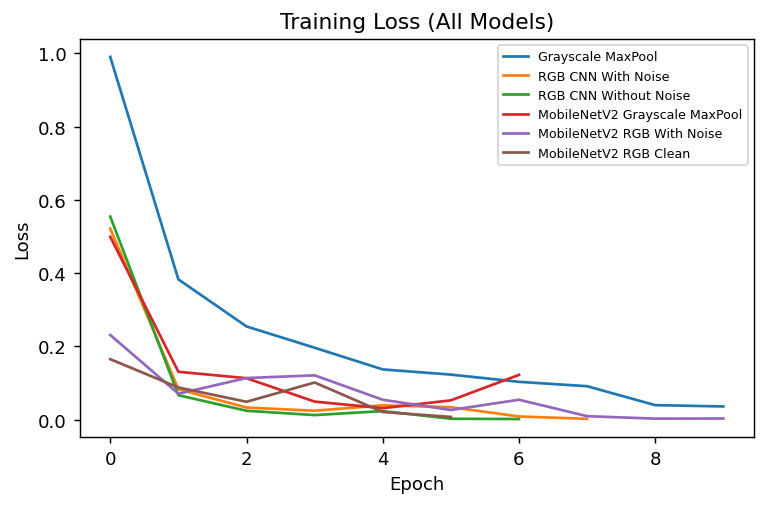

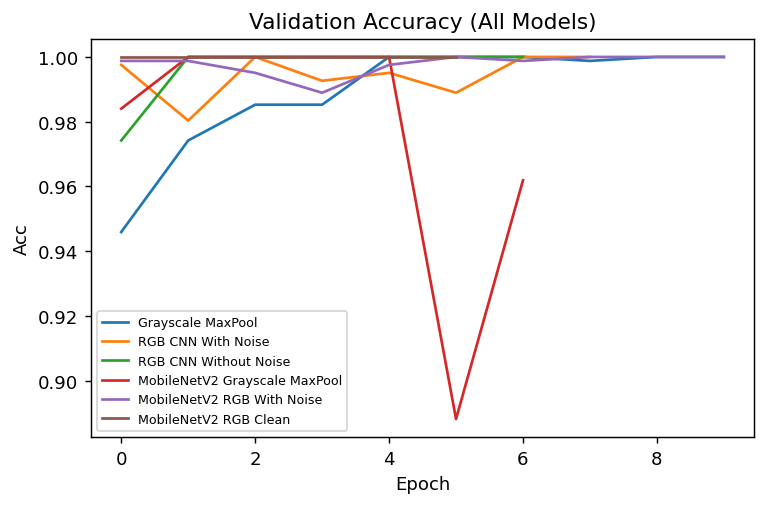

Saved → ../experiments/plots/learning_curves_loss.png
Saved → ../experiments/plots/learning_curves_valacc.png


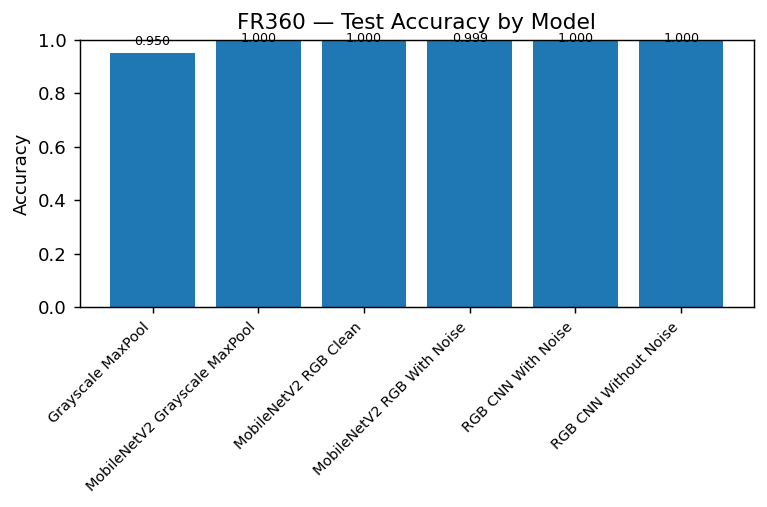

Saved → ../experiments/plots/domain_acc_fr360.png


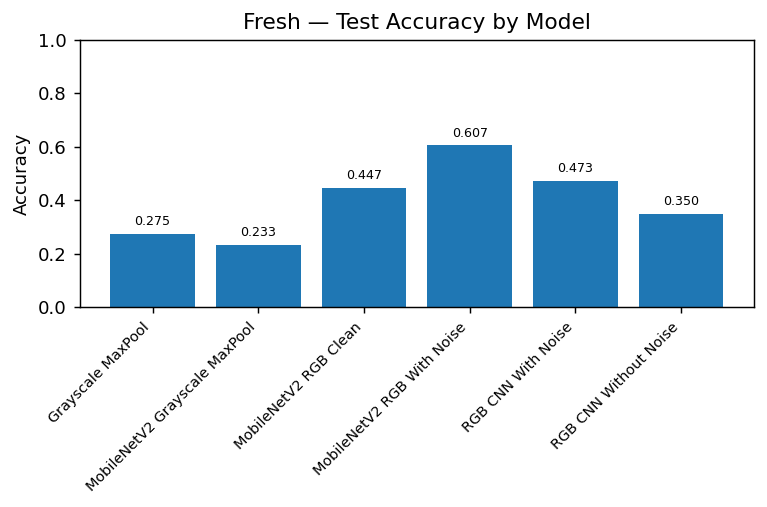

Saved → ../experiments/plots/domain_acc_fresh.png


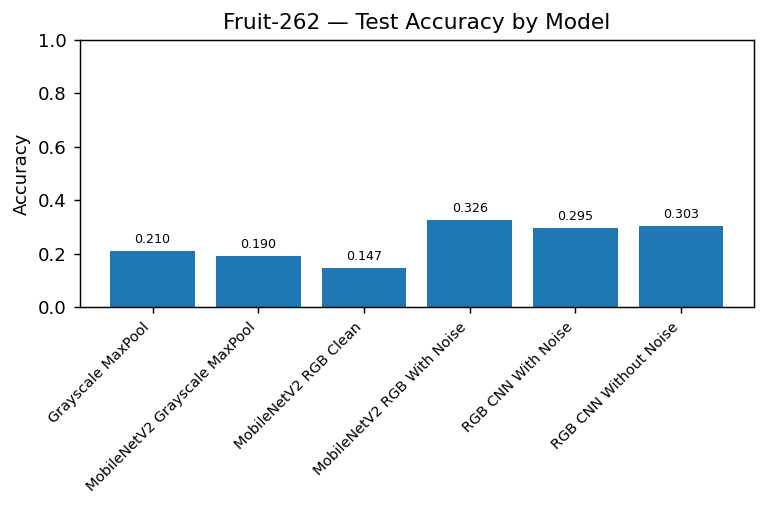

Saved → ../experiments/plots/domain_acc_f262.png


In [16]:
# Cell 7 — Plot learning curves + cross-dataset test accuracies (robust)
import os, json, math
import matplotlib.pyplot as plt

def _load_json(path):
    if not os.path.exists(path):
        print(f"[skip] not found: {path}")
        return {}
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f) or {}
    except Exception as e:
        print(f"[warn] failed to read {path}: {e}")
        return {}

def _extract_curves(entry):
    """
    Supports both schemas:
      • MNV2: {"history": {"train_loss": [...], "val_acc": [...]} }
      • CNN : {"train_losses": [...], "val_accuracies": [...]}
    Returns (train_loss_list, val_acc_list)
    """
    if not isinstance(entry, dict):
        return [], []
    h = entry.get("history")
    if isinstance(h, dict):
        tl = h.get("train_loss", []) or h.get("loss", []) or []
        va = h.get("val_acc", []) or h.get("val_accuracy", []) or []
    else:
        tl = entry.get("train_losses", []) or []
        va = entry.get("val_accuracies", []) or []
    # coerce to float
    def _flt(xs):
        out = []
        for x in xs:
            try: out.append(float(x))
            except Exception: pass
        return out
    return _flt(tl), _flt(va)

def _collect_curves(json_paths):
    """Return dict: name -> {'tl':[], 'va':[]} from multiple files."""
    curves = {}
    for p in json_paths:
        data = _load_json(p)
        for name, d in data.items():
            tl, va = _extract_curves(d)
            if tl or va:
                curves[name] = {'tl': tl, 'va': va}
    return curves

def _collect_domain_accs(json_paths):
    """
    Build dict: name -> {'fr360': float|None, 'fresh': float|None, 'f262': float|None}
      • From MNV2 file: entry.get('accuracies', {})
      • From CNN file : keys 'fr360_test_acc'/'test_accuracy', 'fresh_acc', 'f262_acc'
    """
    accs = {}

    for p in json_paths:
        data = _load_json(p)
        for name, d in data.items():
            fr = None; frsh = None; f262 = None

            # MNV2 style
            if isinstance(d, dict) and "accuracies" in d:
                a = d.get("accuracies", {}) or {}
                fr   = a.get("fr360", fr)
                frsh = a.get("fresh", frsh)
                f262 = a.get("f262",  f262)

            # CNN style fallbacks
            if fr is None:
                fr = d.get("fr360_test_acc", d.get("test_accuracy", None))
            if frsh is None:
                frsh = d.get("fresh_acc", None)
            if f262 is None:
                f262 = d.get("f262_acc", None)

            if any(v is not None for v in (fr, frsh, f262)):
                accs[name] = {'fr360': fr, 'fresh': frsh, 'f262': f262}

    return accs

# -------- 1) Learning curves (from both files) --------
cnn_path  = "../experiments/results/custom_cnn_results.json"
mnv2_path = "../experiments/results/mobilenetv2_results.json"

curves = _collect_curves([cnn_path, mnv2_path])

fig1, ax1 = plt.subplots(figsize=(6,4), dpi=130)  # Training Loss
fig2, ax2 = plt.subplots(figsize=(6,4), dpi=130)  # Validation Accuracy

plotted_loss = plotted_acc = 0
for name, d in curves.items():
    if d['tl']:
        ax1.plot(d['tl'], label=name); plotted_loss += 1
    if d['va']:
        ax2.plot(d['va'], label=name); plotted_acc += 1

ax1.set_title("Training Loss (All Models)")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
if plotted_loss: ax1.legend(fontsize=7)

ax2.set_title("Validation Accuracy (All Models)")
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Acc")
if plotted_acc: ax2.legend(fontsize=7)

os.makedirs("../experiments/plots", exist_ok=True)
fig1.tight_layout(); fig2.tight_layout()
fig1.savefig("../experiments/plots/learning_curves_loss.png", bbox_inches="tight")
fig2.savefig("../experiments/plots/learning_curves_valacc.png", bbox_inches="tight")
plt.show()
plt.close(fig1); plt.close(fig2)

print("Saved → ../experiments/plots/learning_curves_loss.png")
print("Saved → ../experiments/plots/learning_curves_valacc.png")

# -------- 2) Cross-dataset test accuracies (bars) --------
domain_accs = _collect_domain_accs([cnn_path, mnv2_path])

# keep a stable model order (sorted by name)
model_names = sorted(domain_accs.keys())

def _barplot_domain(domain_key, title, out_png):
    vals = [domain_accs[n].get(domain_key) for n in model_names]
    # drop models with None for this domain
    names = [n for n, v in zip(model_names, vals) if v is not None]
    vals  = [v for v in vals if v is not None]
    if not vals:
        print(f"[info] no accuracies found for domain '{domain_key}', skipping plot.")
        return
    fig, ax = plt.subplots(figsize=(max(6, 0.2*len(names)+4), 4), dpi=130)
    ax.bar(range(len(names)), vals)
    ax.set_xticks(range(len(names))); ax.set_xticklabels(names, rotation=45, ha="right", fontsize=8)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Accuracy"); ax.set_title(title)
    # annotate bars
    for i, v in enumerate(vals):
        ax.text(i, min(0.98, v + 0.02), f"{v:.3f}", ha="center", va="bottom", fontsize=7)
    fig.tight_layout()
    fig.savefig(out_png, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved → {out_png}")

_barplot_domain("fr360", "FR360 — Test Accuracy by Model", "../experiments/plots/domain_acc_fr360.png")
_barplot_domain("fresh", "Fresh — Test Accuracy by Model", "../experiments/plots/domain_acc_fresh.png")
_barplot_domain("f262",  "Fruit-262 — Test Accuracy by Model", "../experiments/plots/domain_acc_f262.png")


In [18]:
# Cell X — Backfill Custom CNN predictions on Fresh & F262 (no retraining)
import os, json, torch
from models.cnn_small import create_fruit_cnn
from data import build_domain_loaders

# load CNN results (has ckpt path + mode/in_channels)
cnn_json_path = "../experiments/results/custom_cnn_results.json"
with open(cnn_json_path, "r", encoding="utf-8") as f:
    cnn_res = json.load(f)

# dataset config: canonical list + roots + maps
with open("../configs/dataset_config.json", "r", encoding="utf-8") as f:
    C = json.load(f)

def build_domains_for(mode):
    return build_domain_loaders(
        canonical_classes=C["canonical_classes"],
        fresh_root=C["fresh_root"], fresh_map=C["fresh_map"],
        f262_root=C["f262_root"],   f262_map=C["f262_map"],
        mode=mode, batch_size=32, img_size=C.get("img_size", 100), num_workers=0
    )

device = "cuda" if torch.cuda.is_available() else "cpu"

for name, entry in cnn_res.items():
    ckpt = entry.get("ckpt")
    if not ckpt or not os.path.exists(ckpt):
        print(f"[skip] {name}: missing ckpt at {ckpt}")
        continue

    mode      = entry.get("mode", "grayscale")
    in_ch     = entry.get("in_channels", 1 if mode=="grayscale" else 3)
    classes   = entry.get("class_names", C["canonical_classes"])
    n_classes = len(classes)

    # pick pooling from the experiment name (matches how you trained)
    pooling = "adaptiveavg" if "adaptive" in name.lower() else "max"

    model = create_fruit_cnn(pooling=pooling, in_channels=in_ch, num_classes=n_classes)

    # safer load across torch versions
    try:
        state = torch.load(ckpt, map_location=device, weights_only=True)
    except TypeError:
        state = torch.load(ckpt, map_location=device)
    if isinstance(state, dict) and "state_dict" in state:
        state = state["state_dict"]
    model.load_state_dict(state, strict=False)
    model.eval().to(device)

    domains = build_domains_for(mode)

    # run eval + save JSON + PNG; also populates pred_store/prob_store if they exist
    evaluate_and_save(f"{name} — Fresh (CNN)", model, domains["fresh_eval"], device=device)
    evaluate_and_save(f"{name} — F262 (CNN)",  model, domains["f262_test"], device=device)

print("Backfilled CNN preds for Fresh & F262.")


C:\Users\diots\AppData\Roaming\Python\Python311\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


[Grayscale MaxPool — Fresh (CNN)] acc=0.2750 → ../experiments/results/Grayscale_MaxPool_Fresh_CNN_report.json
[Grayscale MaxPool — F262 (CNN)] acc=0.2095 → ../experiments/results/Grayscale_MaxPool_F262_CNN_report.json
[RGB CNN With Noise — Fresh (CNN)] acc=0.4733 → ../experiments/results/RGB_CNN_With_Noise_Fresh_CNN_report.json
[RGB CNN With Noise — F262 (CNN)] acc=0.2952 → ../experiments/results/RGB_CNN_With_Noise_F262_CNN_report.json
[RGB CNN Without Noise — Fresh (CNN)] acc=0.3500 → ../experiments/results/RGB_CNN_Without_Noise_Fresh_CNN_report.json
[RGB CNN Without Noise — F262 (CNN)] acc=0.3029 → ../experiments/results/RGB_CNN_Without_Noise_F262_CNN_report.json
Backfilled CNN preds for Fresh & F262. Now run your confusion-matrix cell.


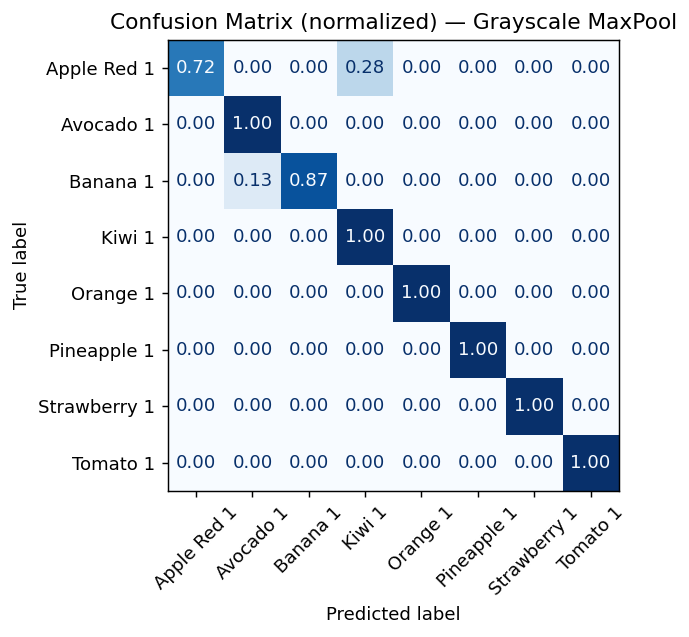

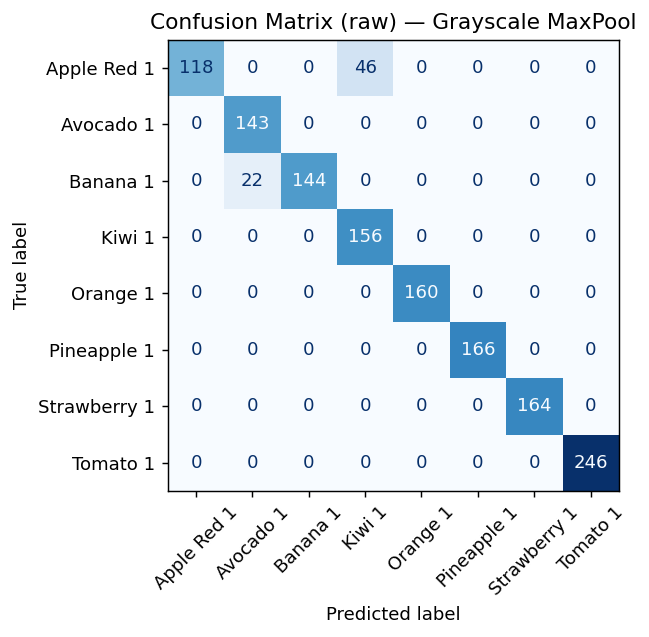

[saved] ../experiments/plots\Grayscale_MaxPool_cm_norm.png
[saved] ../experiments/plots\Grayscale_MaxPool_cm_raw.png


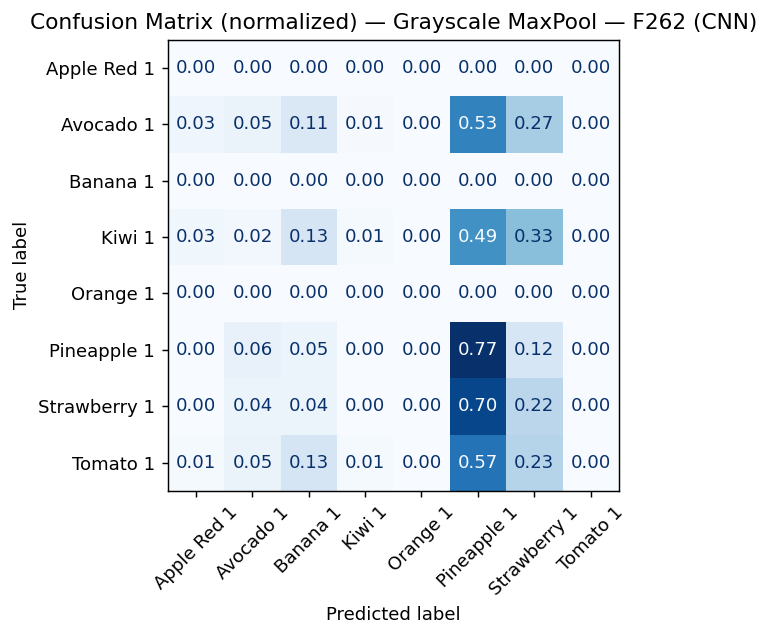

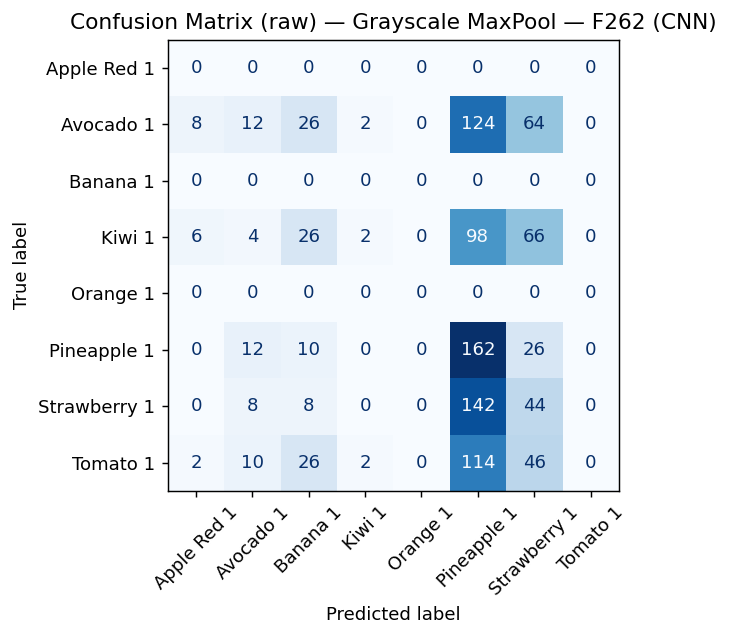

[saved] ../experiments/plots\Grayscale_MaxPool_F262_CNN_cm_norm.png
[saved] ../experiments/plots\Grayscale_MaxPool_F262_CNN_cm_raw.png


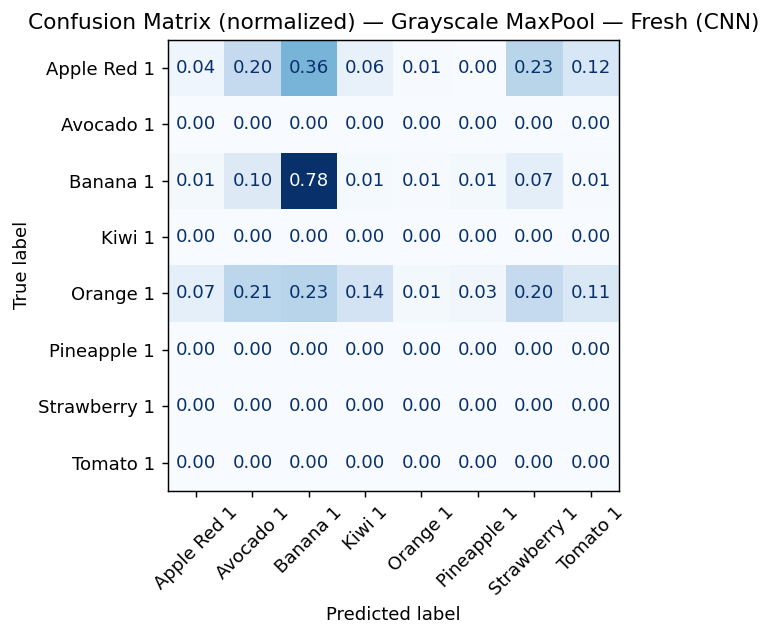

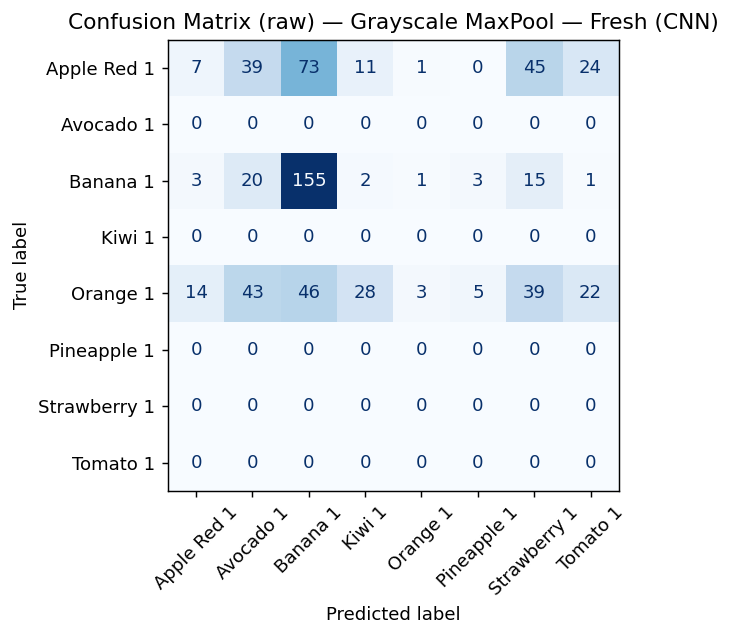

[saved] ../experiments/plots\Grayscale_MaxPool_Fresh_CNN_cm_norm.png
[saved] ../experiments/plots\Grayscale_MaxPool_Fresh_CNN_cm_raw.png


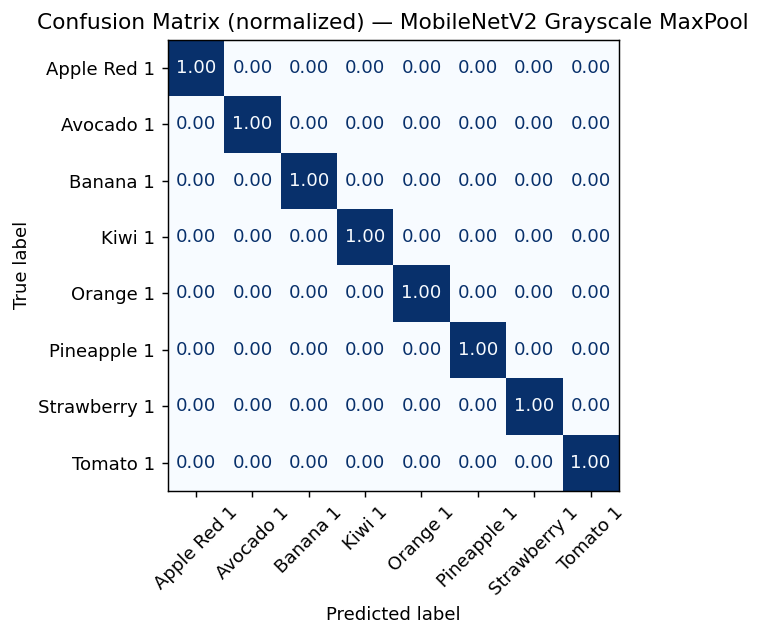

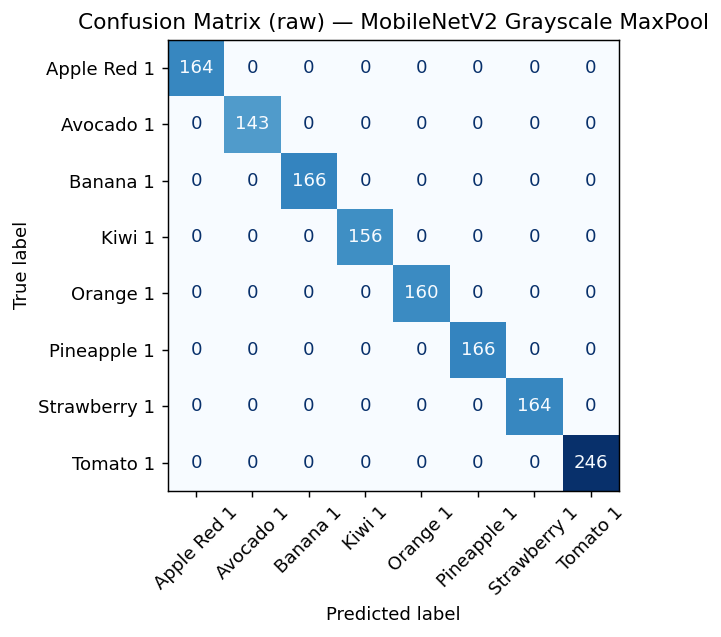

[saved] ../experiments/plots\MobileNetV2_Grayscale_MaxPool_cm_norm.png
[saved] ../experiments/plots\MobileNetV2_Grayscale_MaxPool_cm_raw.png


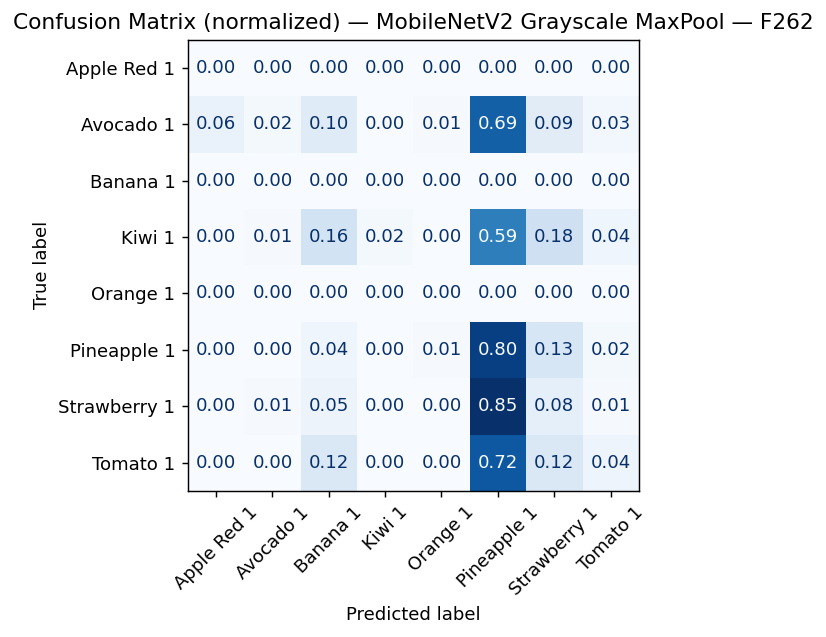

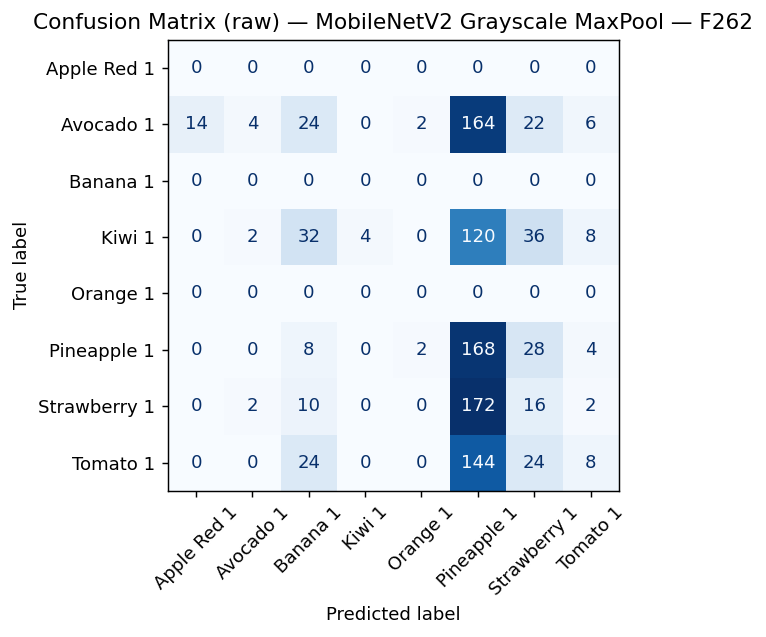

[saved] ../experiments/plots\MobileNetV2_Grayscale_MaxPool_F262_cm_norm.png
[saved] ../experiments/plots\MobileNetV2_Grayscale_MaxPool_F262_cm_raw.png


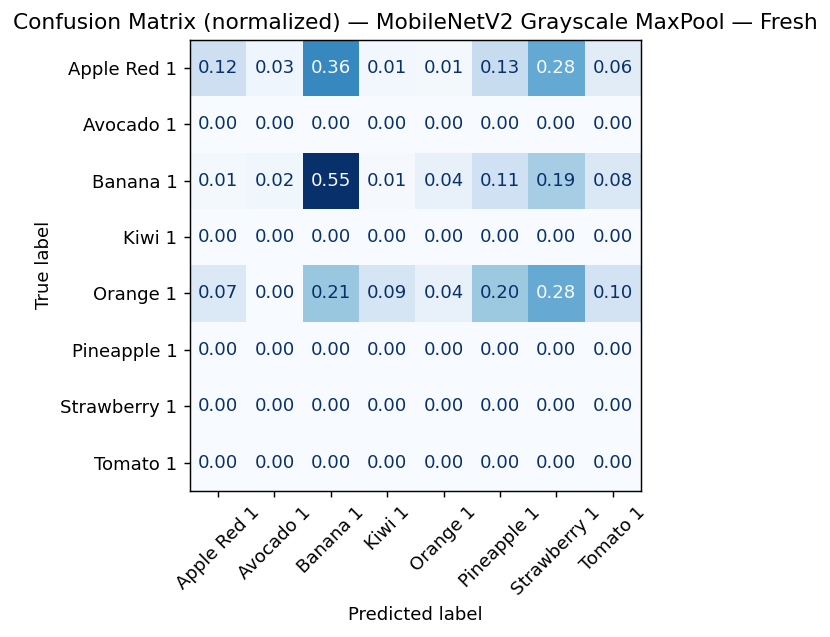

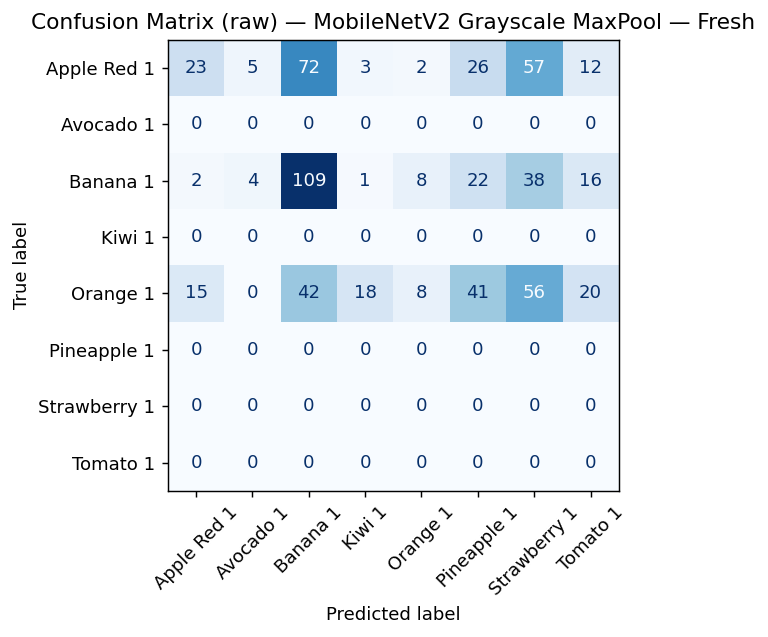

[saved] ../experiments/plots\MobileNetV2_Grayscale_MaxPool_Fresh_cm_norm.png
[saved] ../experiments/plots\MobileNetV2_Grayscale_MaxPool_Fresh_cm_raw.png


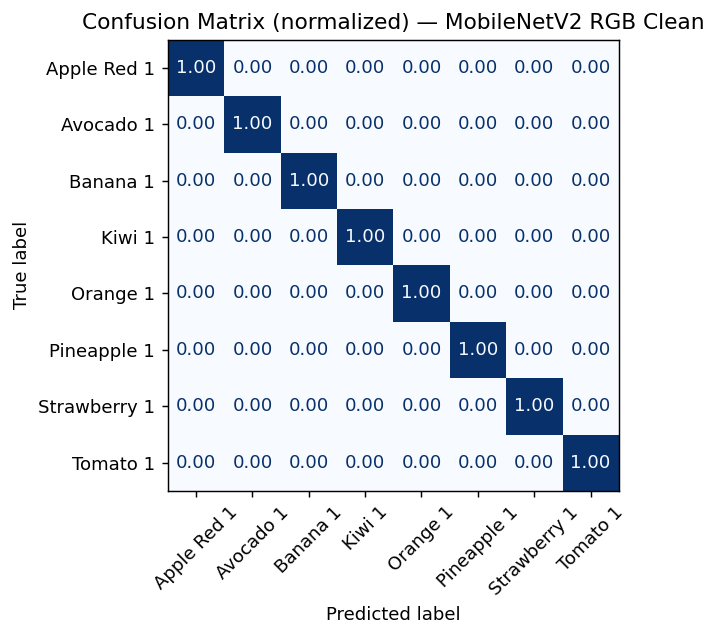

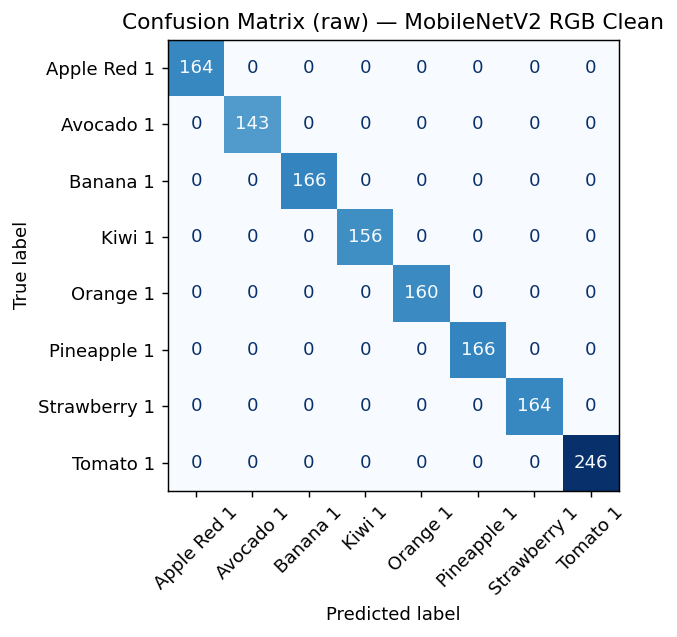

[saved] ../experiments/plots\MobileNetV2_RGB_Clean_cm_norm.png
[saved] ../experiments/plots\MobileNetV2_RGB_Clean_cm_raw.png


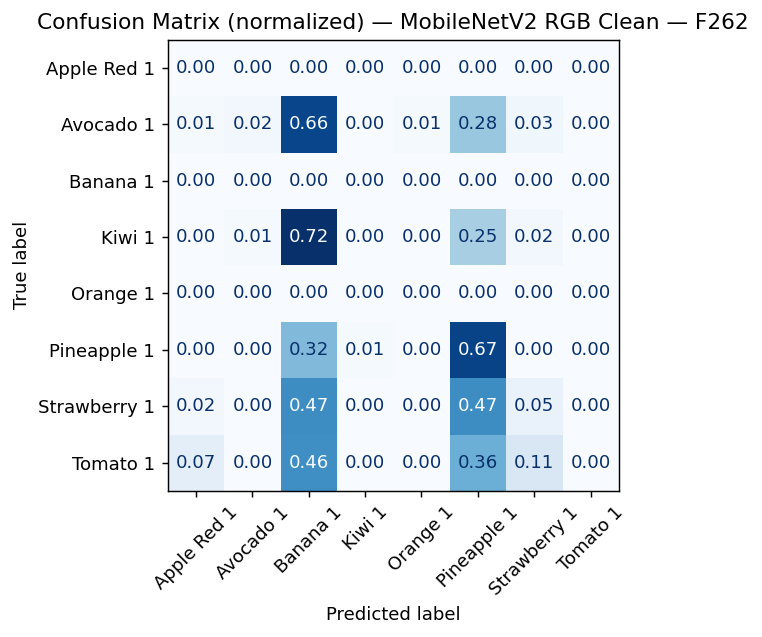

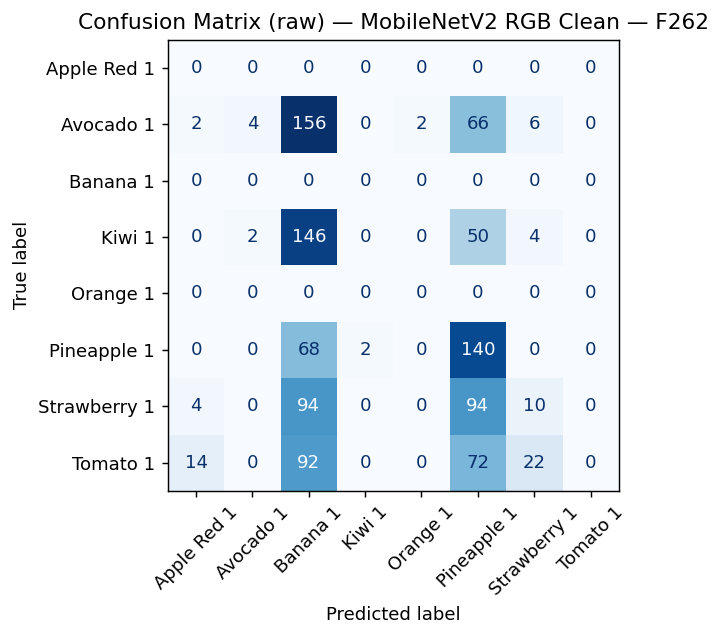

[saved] ../experiments/plots\MobileNetV2_RGB_Clean_F262_cm_norm.png
[saved] ../experiments/plots\MobileNetV2_RGB_Clean_F262_cm_raw.png


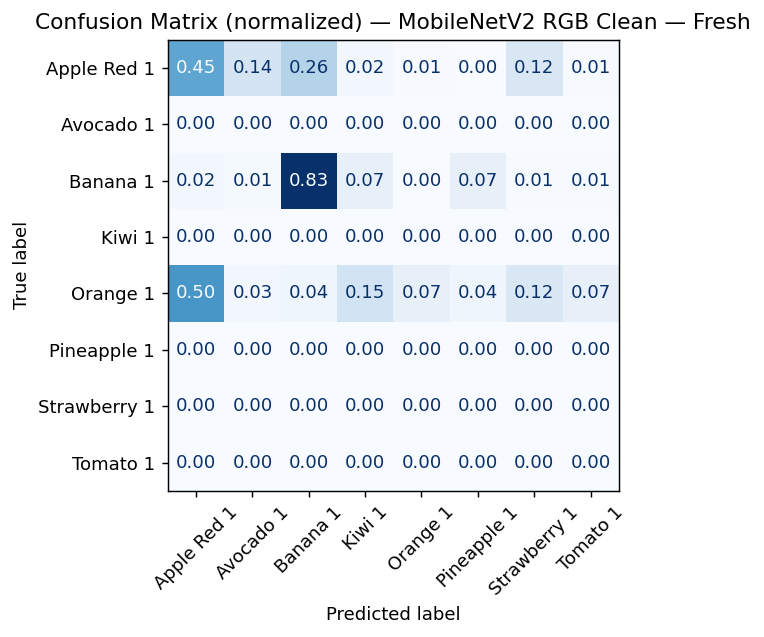

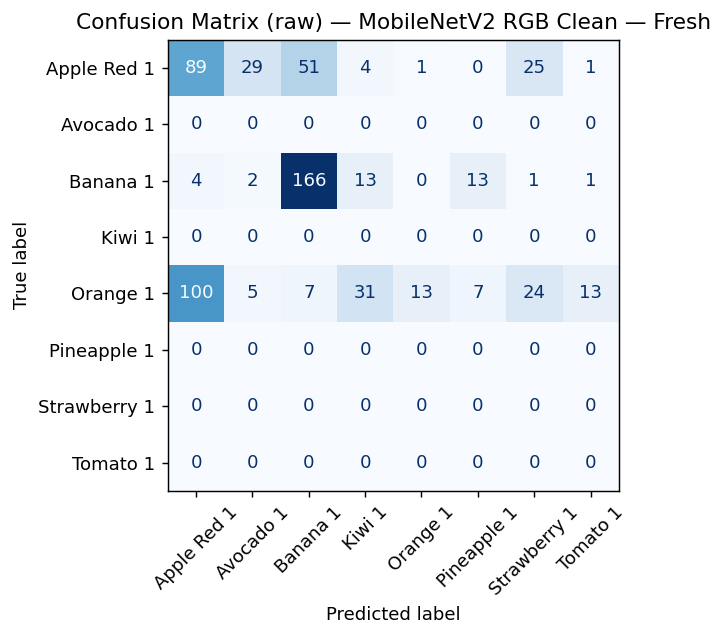

[saved] ../experiments/plots\MobileNetV2_RGB_Clean_Fresh_cm_norm.png
[saved] ../experiments/plots\MobileNetV2_RGB_Clean_Fresh_cm_raw.png


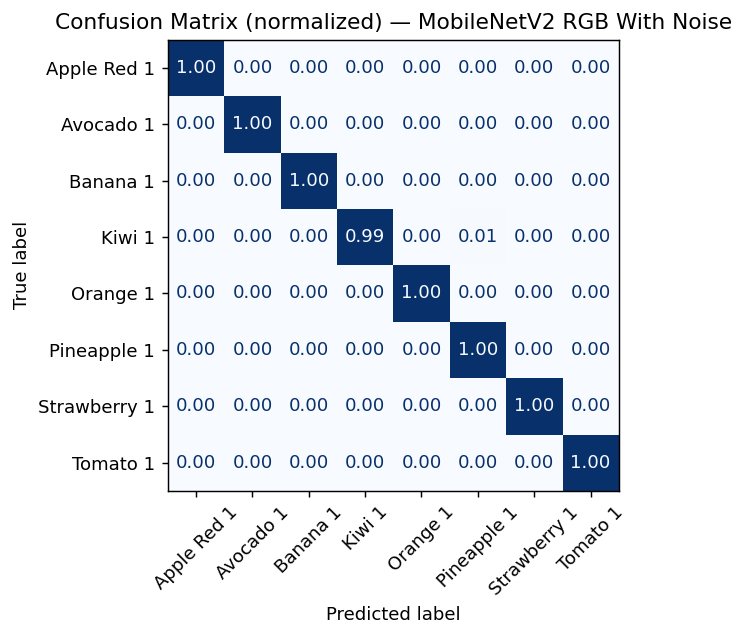

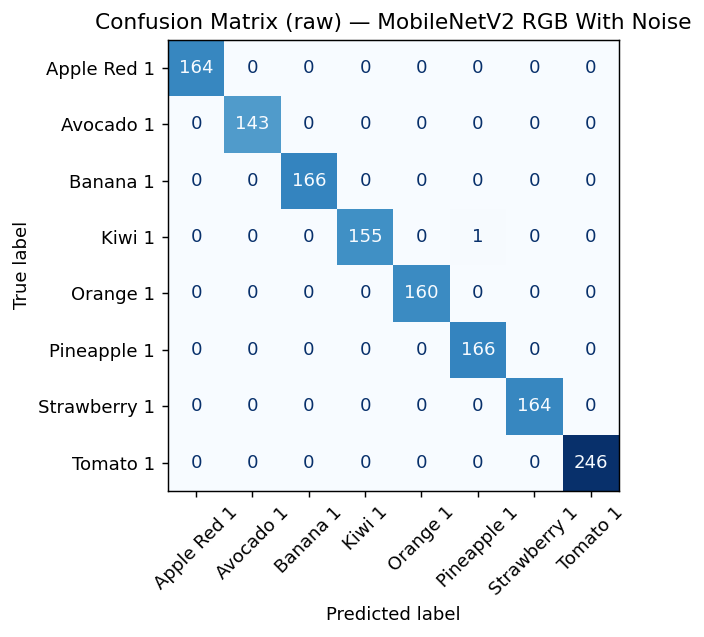

[saved] ../experiments/plots\MobileNetV2_RGB_With_Noise_cm_norm.png
[saved] ../experiments/plots\MobileNetV2_RGB_With_Noise_cm_raw.png


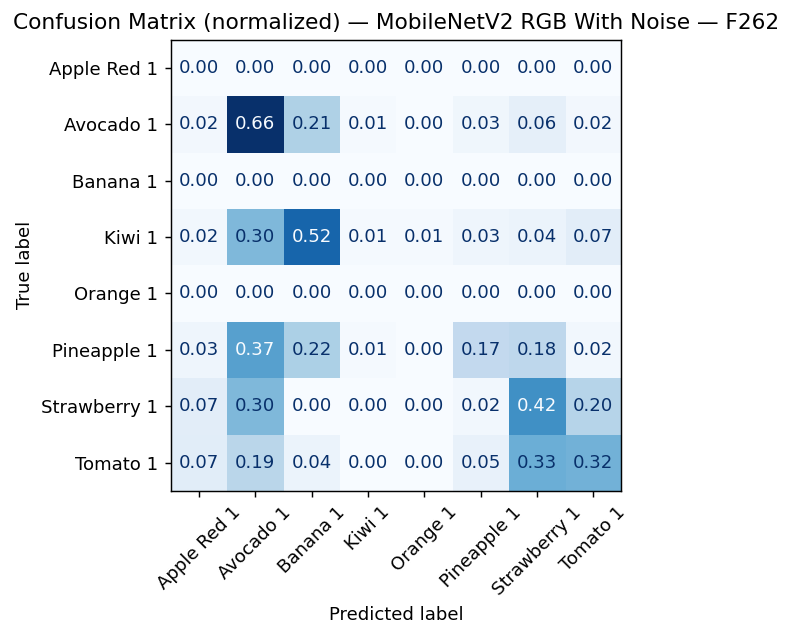

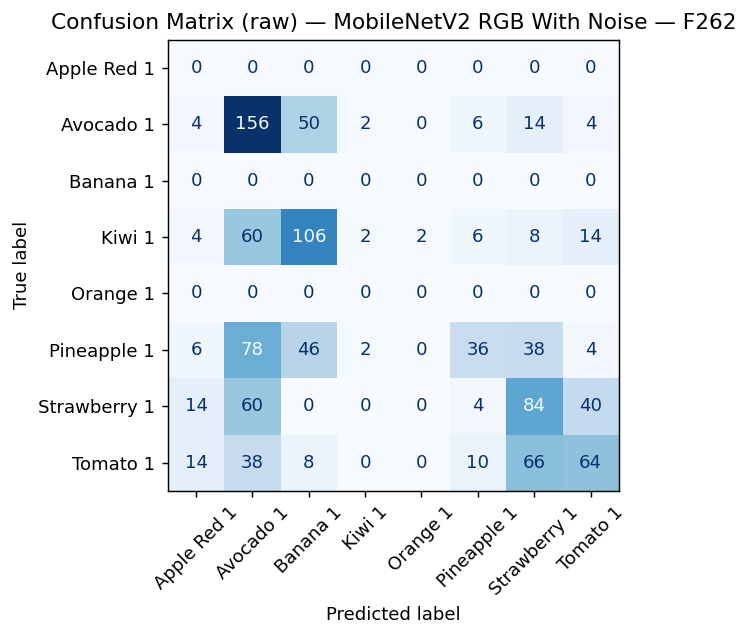

[saved] ../experiments/plots\MobileNetV2_RGB_With_Noise_F262_cm_norm.png
[saved] ../experiments/plots\MobileNetV2_RGB_With_Noise_F262_cm_raw.png


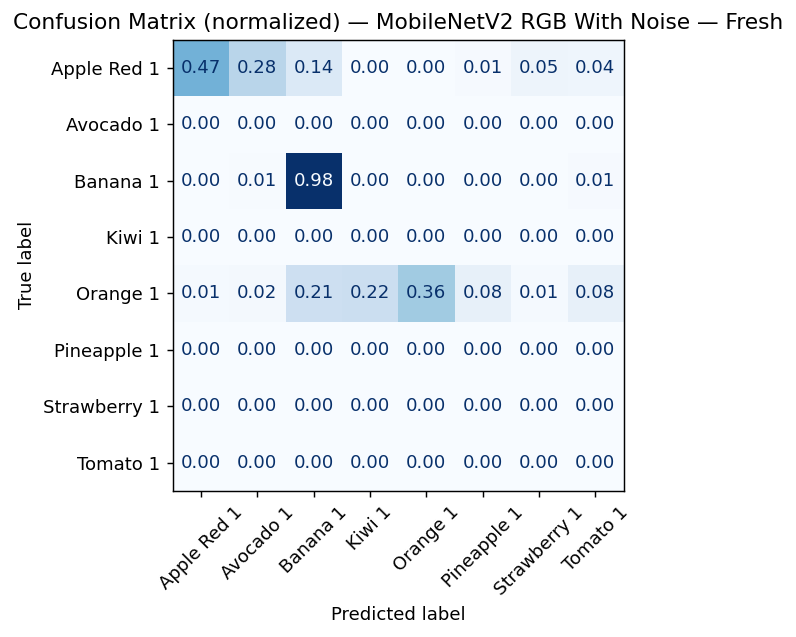

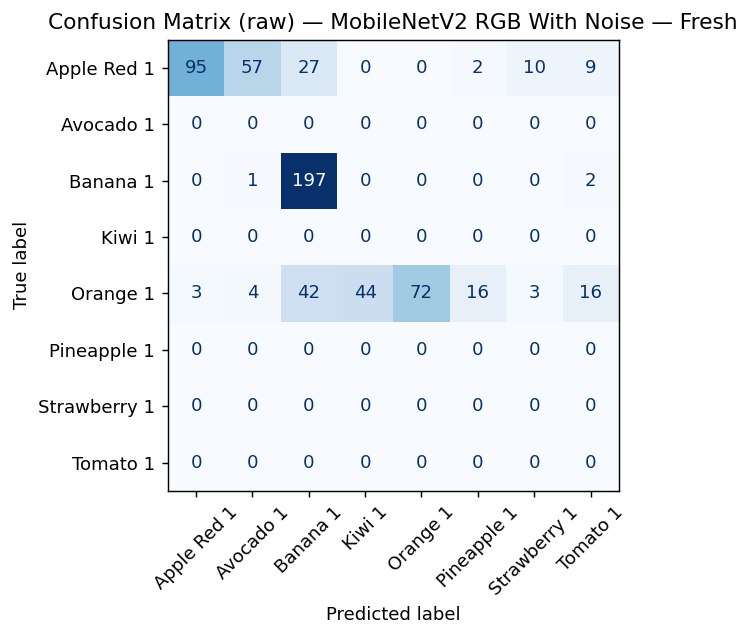

[saved] ../experiments/plots\MobileNetV2_RGB_With_Noise_Fresh_cm_norm.png
[saved] ../experiments/plots\MobileNetV2_RGB_With_Noise_Fresh_cm_raw.png


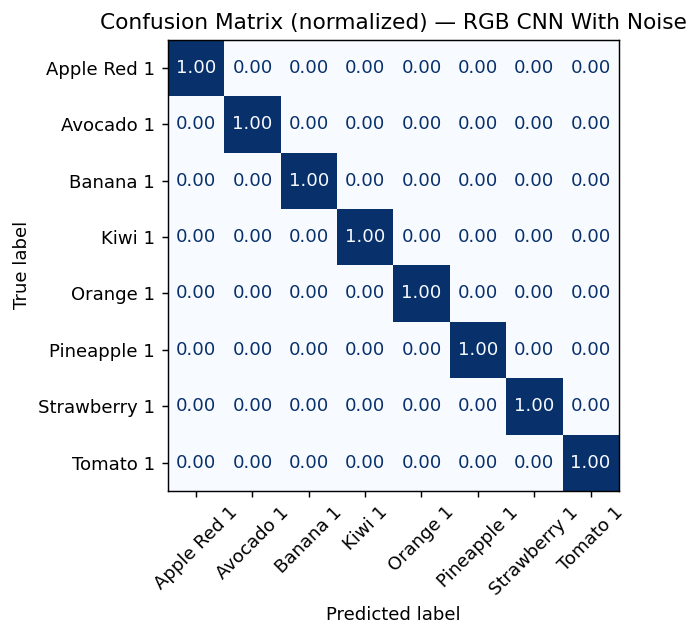

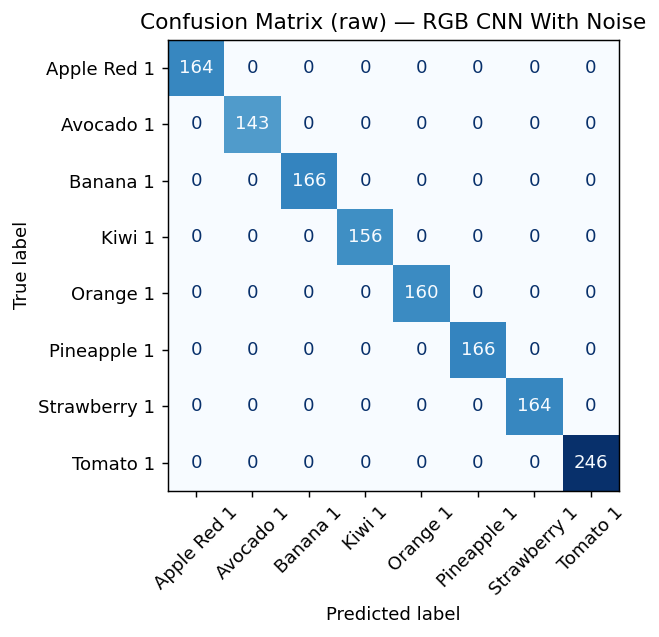

[saved] ../experiments/plots\RGB_CNN_With_Noise_cm_norm.png
[saved] ../experiments/plots\RGB_CNN_With_Noise_cm_raw.png


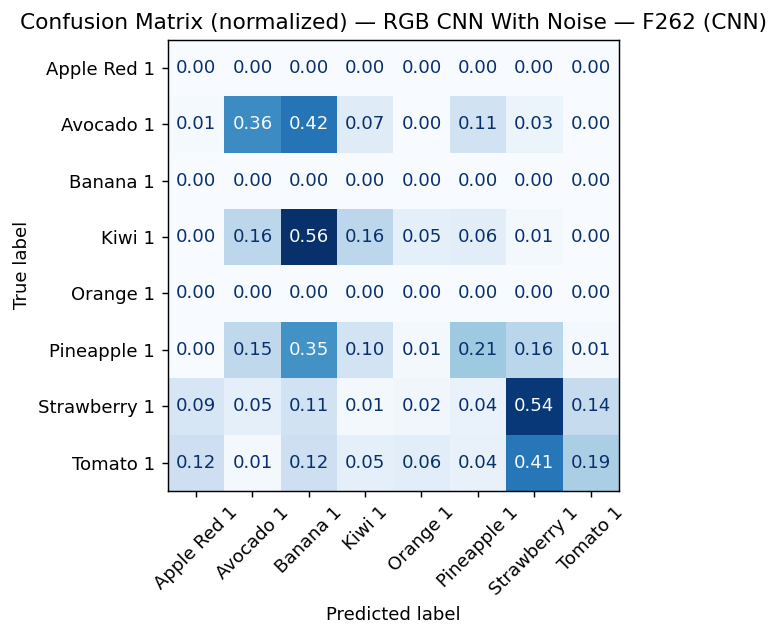

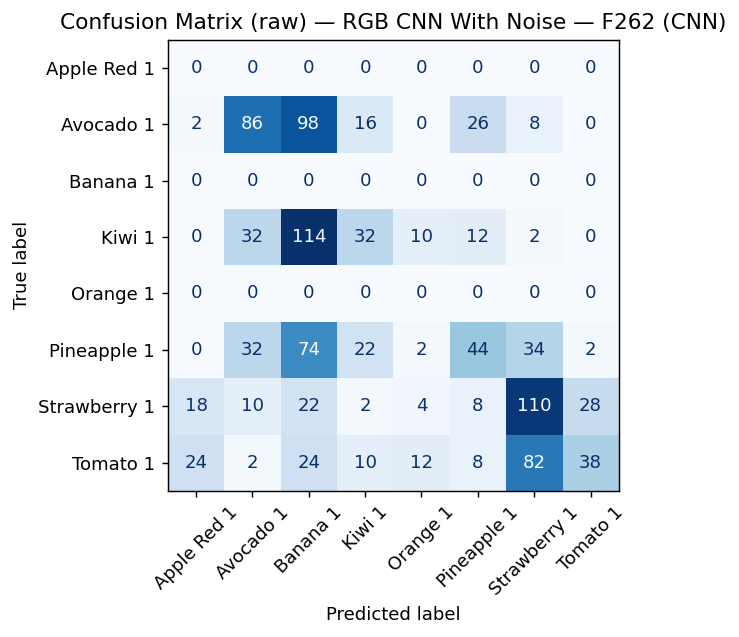

[saved] ../experiments/plots\RGB_CNN_With_Noise_F262_CNN_cm_norm.png
[saved] ../experiments/plots\RGB_CNN_With_Noise_F262_CNN_cm_raw.png


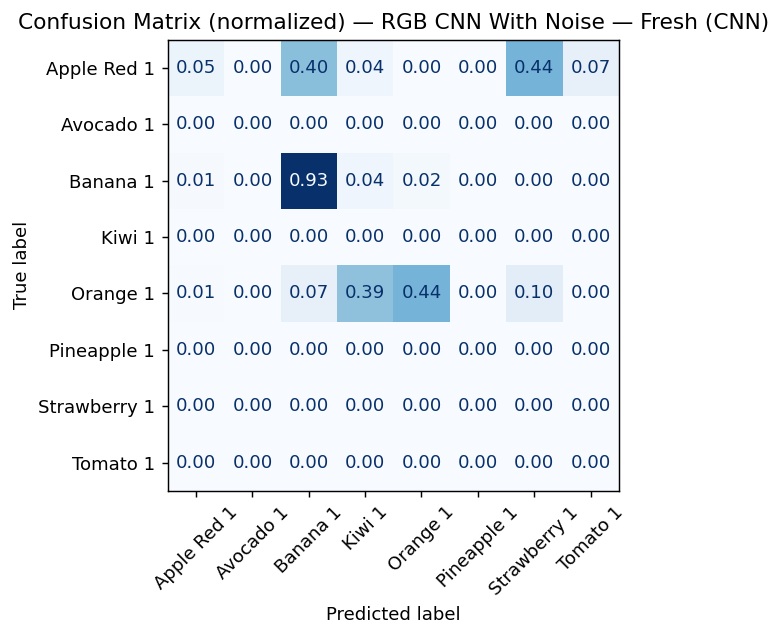

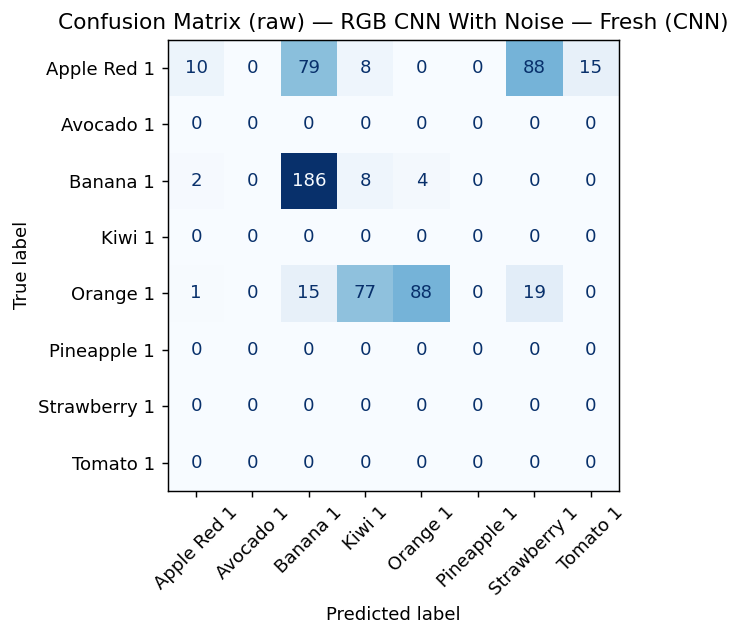

[saved] ../experiments/plots\RGB_CNN_With_Noise_Fresh_CNN_cm_norm.png
[saved] ../experiments/plots\RGB_CNN_With_Noise_Fresh_CNN_cm_raw.png


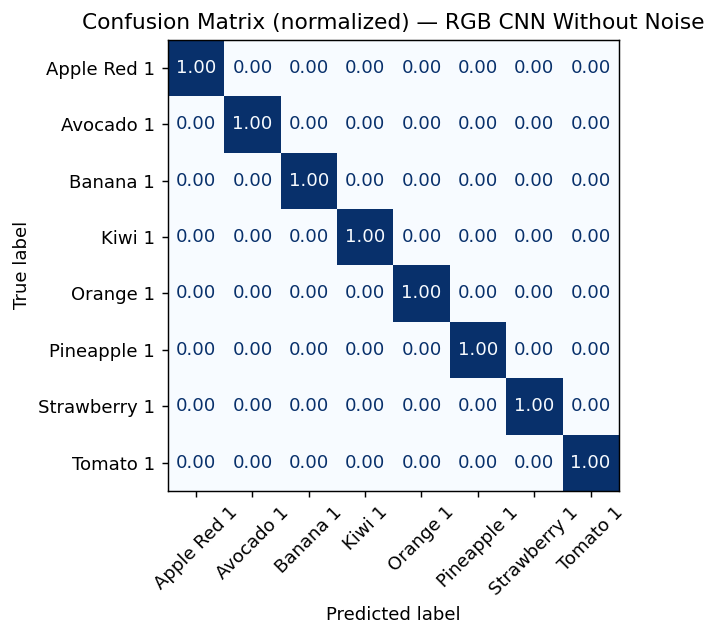

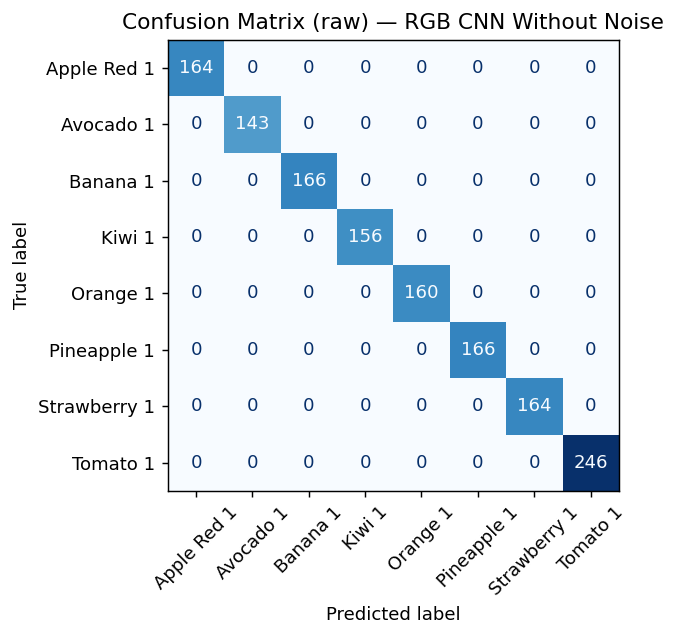

[saved] ../experiments/plots\RGB_CNN_Without_Noise_cm_norm.png
[saved] ../experiments/plots\RGB_CNN_Without_Noise_cm_raw.png


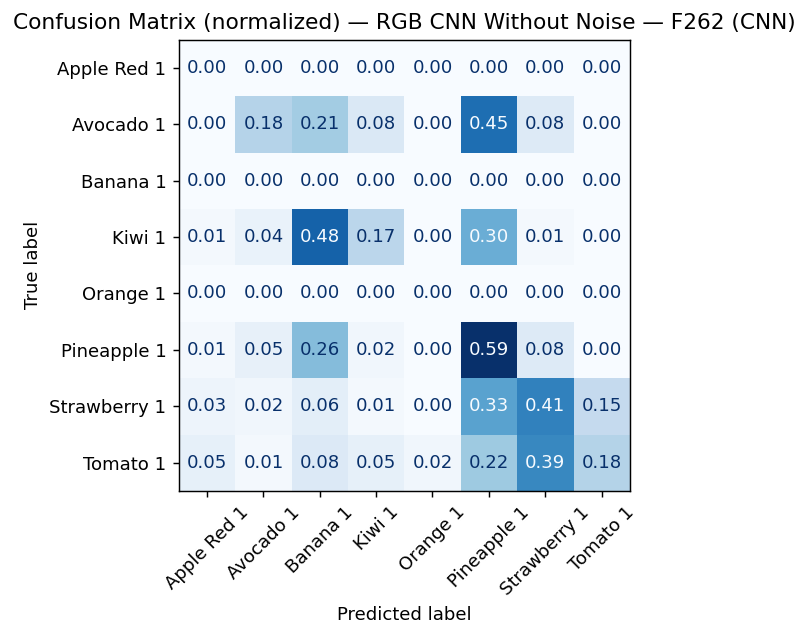

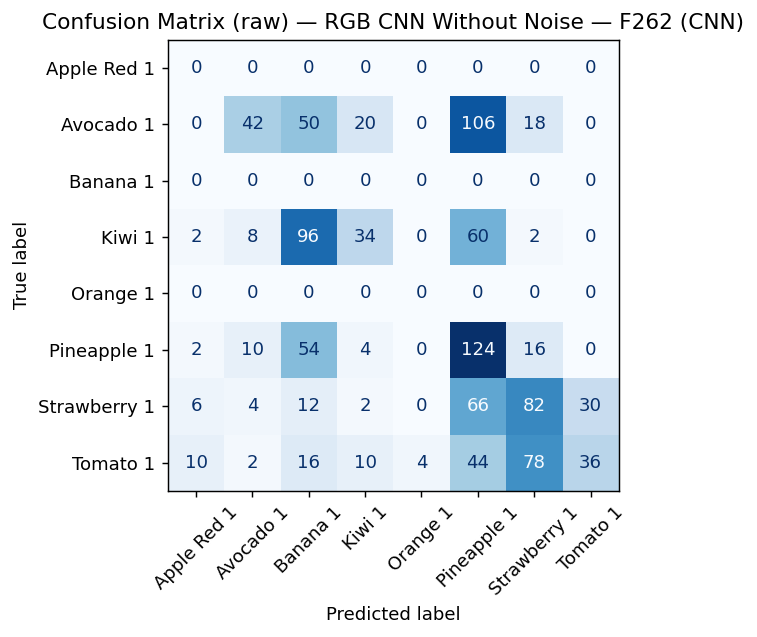

[saved] ../experiments/plots\RGB_CNN_Without_Noise_F262_CNN_cm_norm.png
[saved] ../experiments/plots\RGB_CNN_Without_Noise_F262_CNN_cm_raw.png


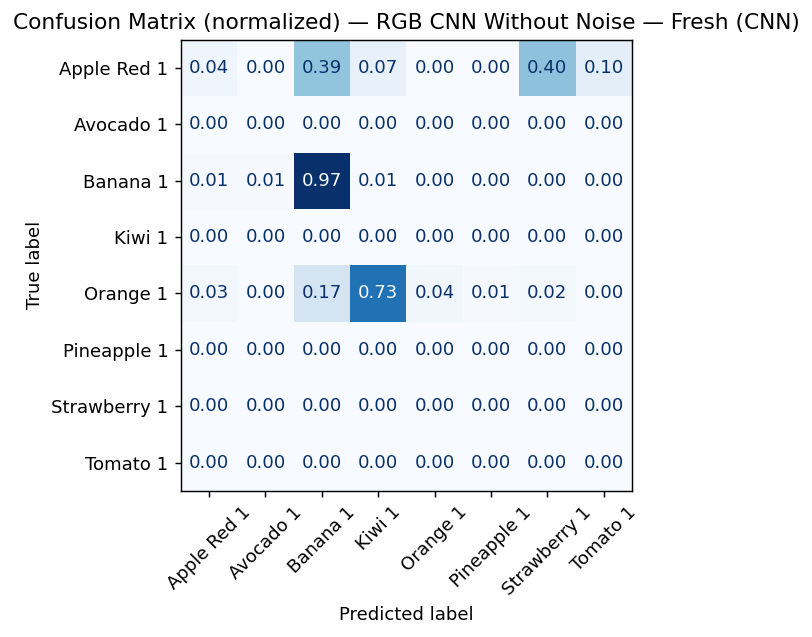

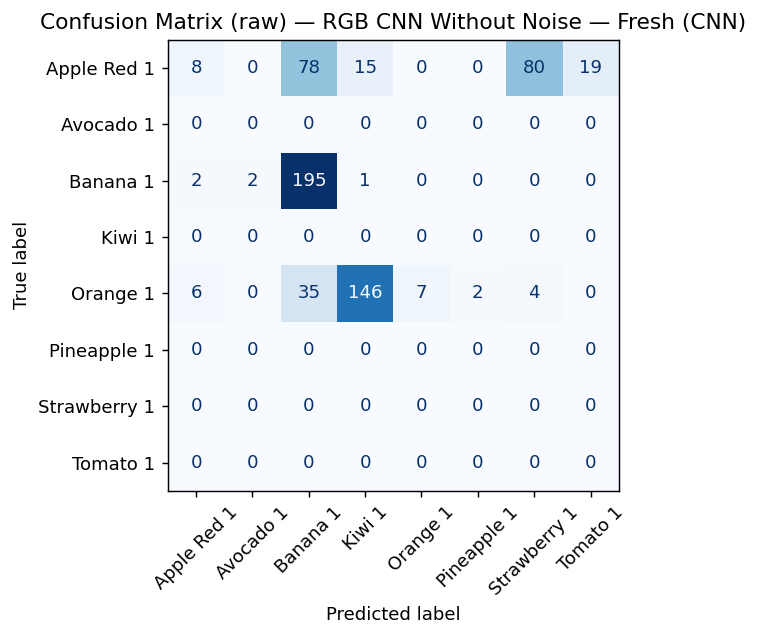

[saved] ../experiments/plots\RGB_CNN_Without_Noise_Fresh_CNN_cm_norm.png
[saved] ../experiments/plots\RGB_CNN_Without_Noise_Fresh_CNN_cm_raw.png


In [19]:
#  Confusion matrices for ALL models/domains in pred_store (raw + normalized)
import os, re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# slug helper (safe filename)
def slugify(s): 
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", str(s) if s is not None else "").strip("_")

out_dir = "../experiments/plots"
os.makedirs(out_dir, exist_ok=True)

if not pred_store:
    print("pred_store is empty. Run the earlier cells that populate it (Step 3 + Step 4).")
else:
    # stable order
    for name in sorted(pred_store.keys()):
        bundle = pred_store[name]
        y_true = np.asarray(bundle["y_true"])
        y_pred = np.asarray(bundle["y_pred"])
        class_names = bundle.get("class_names", None)

        # --- resolve class_names ---
        if class_names is None:
            if y_true.size:
                k = int(max(y_true.max(), y_pred.max())) + 1
            else:
                k = 0
            class_names = [f"class_{i}" for i in range(k)]
        labels_idx = list(range(len(class_names)))  # enforce canonical order

        # --- compute CMs (raw + normalized with zero-row guard) ---
        cm_raw = confusion_matrix(y_true, y_pred, labels=labels_idx)
        row_sum = cm_raw.sum(axis=1, keepdims=True)
        row_sum[row_sum == 0] = 1  # avoid /0 if a class has no true samples
        cm_norm = cm_raw.astype(float) / row_sum

        # --- plot & save: normalized ---
        fig_norm, ax_norm = plt.subplots(figsize=(6, 5), dpi=130)
        disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
        disp_norm.plot(include_values=True, cmap="Blues", xticks_rotation=45,
                       values_format=".2f", colorbar=False, ax=ax_norm)
        ax_norm.set_title(f"Confusion Matrix (normalized) — {name}")
        fig_norm.tight_layout()
        out_norm = os.path.join(out_dir, f"{slugify(name)}_cm_norm.png")
        fig_norm.savefig(out_norm, bbox_inches="tight")
        plt.show(); plt.close(fig_norm)

        # --- plot & save: raw counts ---
        fig_raw, ax_raw = plt.subplots(figsize=(6, 5), dpi=130)
        disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=class_names)
        disp_raw.plot(include_values=True, cmap="Blues", xticks_rotation=45,
                      values_format="d", colorbar=False, ax=ax_raw)
        ax_raw.set_title(f"Confusion Matrix (raw) — {name}")
        fig_raw.tight_layout()
        out_raw = os.path.join(out_dir, f"{slugify(name)}_cm_raw.png")
        fig_raw.savefig(out_raw, bbox_inches="tight")
        plt.show(); plt.close(fig_raw)

        print(f"[saved] {out_norm}")
        print(f"[saved] {out_raw}")



### 4.3 Aggregate comparison table (accuracy/F1/size/latency)

In [16]:
# Cell 8 — Build comparison CSV from CNN + MobileNetV2 reports
import json, os, pandas as pd, time

def macro_weighted_f1(report_dict):
    if not report_dict:
        return None, None
    return (
        report_dict.get("macro avg", {}).get("f1-score"),
        report_dict.get("weighted avg", {}).get("f1-score"),
    )

def model_disk_size(path):
    return os.path.getsize(path) / (1024**2) if path and os.path.exists(path) else float("nan")

rows = []

# --- 1) Load Custom CNN results from Step 3 JSON ---
cnn_json_path = "../experiments/results/custom_cnn_results.json"
if os.path.exists(cnn_json_path):
    with open(cnn_json_path, "r", encoding="utf-8") as f:
        cnn_data = json.load(f)
    for name, d in cnn_data.items():
        rows.append({
            "model": name,
            "family": "Custom CNN",
            "accuracy": d.get("test_accuracy"),
            "macro_f1": None,        # filled only if you re-evaluate CNNs with evaluate_and_save
            "weighted_f1": None,
            "ckpt_size_mb": model_disk_size(d.get("ckpt"))
        })

# --- 2) Load MobileNetV2 reports (Step 4) ---
mnv2_names = [
    "MobileNetV2 Grayscale MaxPool",
    "MobileNetV2 Grayscale Adaptive",
    "MobileNetV2 RGB With Noise",
    "MobileNetV2 RGB Clean",
]

name_to_ckpt = {
    "MobileNetV2 Grayscale MaxPool":  "../experiments/runs/mnv2_gray_max.pt",
    "MobileNetV2 Grayscale Adaptive": "../experiments/runs/mnv2_gray_adapt.pt",
    "MobileNetV2 RGB With Noise":     "../experiments/runs/mnv2_rgb_noise.pt",
    "MobileNetV2 RGB Clean":          "../experiments/runs/mnv2_rgb_clean.pt",
}

for n in mnv2_names:
    report_path = f"../experiments/results/{slugify(n)}_report.json"
    if not os.path.exists(report_path):
        print("Missing:", report_path)
        continue
    with open(report_path, "r", encoding="utf-8") as f:
        rep = json.load(f)

    acc = rep["accuracy"]
    macro_f1, weighted_f1 = macro_weighted_f1(rep.get("classification_report", {}))
    size_mb = model_disk_size(name_to_ckpt.get(n, ""))

    rows.append({
        "model": n,
        "family": "MobileNetV2",
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "ckpt_size_mb": size_mb
    })

# --- 3) Build DataFrame ---
df = pd.DataFrame(rows).sort_values(by=["accuracy"], ascending=False)
out_csv = "../experiments/results/model_comparison_all.csv"
df.to_csv(out_csv, index=False)
print("Saved →", out_csv)
df



Saved → ../experiments/results/model_comparison_all.csv


,model,family,accuracy,macro_f1,weighted_f1,ckpt_size_mb
4,MobileNetV2 Grayscale MaxPool,MobileNetV2,0.972894,0.970511,0.972444,8.750902
5,MobileNetV2 Grayscale Adaptive,MobileNetV2,0.936264,0.920878,0.926366,8.751509
2,RGB CNN With Noise,Custom CNN,0.885714,NaN,NaN,9.102806
3,RGB CNN Without Noise,Custom CNN,0.885714,NaN,NaN,9.102846
7,MobileNetV2 RGB Clean,MobileNetV2,0.885714,0.827289,0.841383,8.753342
6,MobileNetV2 RGB With Noise,MobileNetV2,0.884982,0.821492,0.838026,8.753342
1,Grayscale AdaptiveAvgPool,Custom CNN,0.871795,NaN,NaN,9.101801
0,Grayscale MaxPool,Custom CNN,0.833700,NaN,NaN,NaN


### 4.3 McNemar significance test 

In [17]:
# Cell 9 — McNemar across ALL models (Custom CNN + MobileNetV2)
sys.path.append(os.path.abspath("../src"))
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np, os, json, re, torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from models.mobileNetV2compare import prepare_mobilenet_v2, get_mobilenet_loaders

from models.cnn_small import create_fruit_cnn
# --- Paths / globals you already have ---
TRAIN_DIR = '../Dataset/Training'
TEST_DIR  = '../Dataset/Test'
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reuse existing pred_store if present; else create
try:
    pred_store
except NameError:
    pred_store = {}

# ---------- Utilities ----------
def slugify(s): return re.sub(r"[^a-zA-Z0-9_-]+", "_", s).strip("_")

@torch.no_grad()
def _get_preds(model, loader, device):
    model.eval().to(device)
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        y_true.append(yb.numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())
    return np.concatenate(y_true), np.concatenate(y_pred)

def _make_cnn_test_loader(input_type, img_size=(100,100), batch_size=32, use_noise=False):
    if input_type == "grayscale":
        tfm = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
    else:
        tfm = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
        ])
    ds = ImageFolder(TEST_DIR, transform=tfm)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True), ds.classes

def _infer_cnn_spec_from_name(name, in_channels):
    input_type = "grayscale" if in_channels == 1 else "rgb"
    pooling = "max"
    if "Adaptive" in name or "AdaptiveAvgPool" in name:
        pooling = "adaptive"
    # (Optional noise flag, if you encoded it in the name)
    use_noise = "With Noise" in name or "Noise" in name
    return dict(input_type=input_type, pooling=pooling, use_noise=use_noise)

# Known MobileNetV2 experiment specs & ckpts
mnv2_specs = {
    "MobileNetV2 Grayscale MaxPool":  {"ckpt":"../experiments/runs/mnv2_gray_max.pt",  "input_type":"grayscale", "pooling":"max"},
    "MobileNetV2 Grayscale Adaptive": {"ckpt":"../experiments/runs/mnv2_gray_adapt.pt","input_type":"grayscale", "pooling":"adaptive"},
    "MobileNetV2 RGB With Noise":     {"ckpt":"../experiments/runs/mnv2_rgb_noise.pt", "input_type":"rgb",       "pooling":"default"},
    "MobileNetV2 RGB Clean":          {"ckpt":"../experiments/runs/mnv2_rgb_clean.pt", "input_type":"rgb",       "pooling":"default"},
}

# Load CNN JSON once to know names/ckpts/in_channels
cnn_json_path = "../experiments/results/custom_cnn_results.json"
cnn_results = {}
if os.path.exists(cnn_json_path):
    with open(cnn_json_path, "r", encoding="utf-8") as f:
        cnn_results = json.load(f)

def ensure_preds(model_name):
    """Return (y_true, y_pred) for any model name; rebuild+load if needed, then cache in pred_store."""
    if model_name in pred_store:
        return pred_store[model_name]["y_true"], pred_store[model_name]["y_pred"]

    # Case 1: MobileNetV2
    if model_name in mnv2_specs:
        spec = mnv2_specs[model_name]
        # Build test loader via your helper
        _, _, test_loader, _, in_channels = get_mobilenet_loaders(
            TRAIN_DIR, TEST_DIR,
            input_type=spec["input_type"], use_noise=("Noise" in model_name),
            batch_size=32, val_split=0.2  # val_split doesn't affect test_loader content
        )
        # Build model and load ckpt
        # Get num_classes from dataset
        cls_names = getattr(test_loader.dataset, "classes", None)
        num_classes = len(cls_names) if cls_names else 8
        model = prepare_mobilenet_v2(in_channels=in_channels, num_classes=num_classes, pooling=spec["pooling"], pretrained=True)
        if os.path.exists(spec["ckpt"]):
            state = torch.load(spec["ckpt"], map_location=device)
            model.load_state_dict(state)
        y_true, y_pred = _get_preds(model, test_loader, device)
        pred_store[model_name] = {"y_true": y_true, "y_pred": y_pred}
        return y_true, y_pred

    # Case 2: Custom CNN (from Step 3 JSON)
    if model_name in cnn_results:
        entry = cnn_results[model_name]
        ckpt = entry.get("ckpt")
        in_ch = entry.get("in_channels", 3)
        spec = _infer_cnn_spec_from_name(model_name, in_ch)

        test_loader, class_names = _make_cnn_test_loader(spec["input_type"])
        num_classes = len(class_names) if class_names else 8

        # 🔁 Build your small CNN the same way you trained it
        model = create_fruit_cnn(pooling=spec["pooling"], in_channels=in_ch, num_classes=num_classes)
        if ckpt and os.path.exists(ckpt):
            state = torch.load(ckpt, map_location=device)
            model.load_state_dict(state)

        y_true, y_pred = _get_preds(model, test_loader, device)
        pred_store[model_name] = {"y_true": y_true, "y_pred": y_pred}
        return y_true, y_pred

    raise ValueError(f"Unknown model name: {model_name}")

def mcnemar_test(y_true, y_pred_A, y_pred_B):
    A_correct = (y_pred_A == y_true)
    B_correct = (y_pred_B == y_true)
    b = int(np.sum( ( A_correct) & (~B_correct)))
    c = int(np.sum( (~A_correct) & ( B_correct)))
    table = [[0, b], [c, 0]]
    res = mcnemar(table, exact=True)
    return {"b": b, "c": c, "p_value": float(res.pvalue)}

# -------- Choose what to compare --------
# Option 1: pick manually
# A = "MobileNetV2 RGB Clean"
# B = "Grayscale AdaptiveAvgPool"   # example custom CNN name from your JSON

# Option 2: auto-pick best CNN vs best MNV2 by accuracy
def _best_names():
    # best CNN
    best_cnn, best_cnn_acc = None, -1
    for name, d in cnn_results.items():
        acc = d.get("test_accuracy", -1)
        if acc is not None and acc > best_cnn_acc:
            best_cnn, best_cnn_acc = name, acc
    # best MNV2 (from saved reports)
    mnv2_best, mnv2_best_acc = None, -1
    for n in mnv2_specs.keys():
        rpath = f"../experiments/results/{slugify(n)}_report.json"
        if os.path.exists(rpath):
            with open(rpath, "r", encoding="utf-8") as f:
                rep = json.load(f)
            acc = rep.get("accuracy", -1)
            if acc > mnv2_best_acc:
                mnv2_best, mnv2_best_acc = n, acc
    return best_cnn, mnv2_best

A, B = _best_names()  # auto-pick
print(f"Comparing:\n  A = {A}\n  B = {B}")

# -------- Run McNemar --------
y_true_A, y_pred_A = ensure_preds(A)
y_true_B, y_pred_B = ensure_preds(B)
assert np.array_equal(y_true_A, y_true_B), "Test sets must match"
stats = mcnemar_test(y_true_A, y_pred_A, y_pred_B)
print(f"McNemar {A} vs {B} → b={stats['b']} c={stats['c']} p={stats['p_value']:.4g}")



Comparing:
  A = RGB CNN With Noise
  B = MobileNetV2 Grayscale MaxPool
McNemar RGB CNN With Noise vs MobileNetV2 Grayscale MaxPool → b=0 c=119 p=3.009e-36


### 4.4 CNN Quantization
#### Compare FP32 vs Quantized FruitCNN (size, accuracy, speed)

In [20]:

# Cell 9 — McNemar across ALL models (Custom CNN + MobileNetV2) — domain-aware, using pred_store

import os, json, re
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

def slugify(s): 
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", str(s)).strip("_")

# ---- choose domain and models ----
# Domain tag must match how you named results in pred_store:
#   FR360  → keys WITHOUT a " — " suffix (e.g., "MobileNetV2 RGB Clean")
#   Fresh  → keys ending with " — Fresh"
#   F262   → keys ending with " — F262"
DOMAIN = "F262"   # options: "FR360", "Fresh", "F262"

def candidates_for_domain(domain):
    if domain == "FR360":
        return sorted([k for k in pred_store.keys() if " — " not in k])
    tag = f" — {domain}"
    return sorted([k for k in pred_store.keys() if k.endswith(tag)])

avail = candidates_for_domain(DOMAIN)
if not avail:
    raise RuntimeError(
        f"No predictions in pred_store for domain '{DOMAIN}'. "
        f"Make sure you ran the evaluation cells that populate pred_store "
        f"(e.g., the MobileNet cells and the CNN backfill/eval)."
    )

print(f"[Info] Available models for {DOMAIN}:")
for i, k in enumerate(avail, 1):
    yt = pred_store[k]["y_true"]; yp = pred_store[k]["y_pred"]
    acc = (yt == yp).mean()
    print(f"  {i:>2}. {k}  (acc={acc:.4f}, n={len(yt)})")

# Pick two by name (or by index once you see the list printed above)
MODEL_A = avail[0]  # change if you want a different pair
MODEL_B = avail[1]  # change if you want a different pair

print(f"\nComparing with McNemar on {DOMAIN}:\n  A = {MODEL_A}\n  B = {MODEL_B}")

# ---- fetch y_true / y_pred and sanity-check alignment ----
y_true_A = np.asarray(pred_store[MODEL_A]["y_true"])
y_pred_A = np.asarray(pred_store[MODEL_A]["y_pred"])
y_true_B = np.asarray(pred_store[MODEL_B]["y_true"])
y_pred_B = np.asarray(pred_store[MODEL_B]["y_pred"])

if y_true_A.shape != y_true_B.shape or not np.array_equal(y_true_A, y_true_B):
    # Strong guard: McNemar needs the SAME examples in the SAME order.
    raise AssertionError(
        "y_true differs between models. Ensure both predictions were produced on the exact same loader."
    )

y_true = y_true_A

# ---- McNemar: build 2x2 table from per-sample correctness ----
A_correct = (y_pred_A == y_true)
B_correct = (y_pred_B == y_true)
b = int(np.sum( ( A_correct) & (~B_correct)))  # A correct, B wrong
c = int(np.sum( (~A_correct) & ( B_correct)))  # A wrong,   B correct
table = [[0, b],
         [c, 0]]

res = mcnemar(table, exact=True)
pval = float(res.pvalue)

acc_A = A_correct.mean()
acc_B = B_correct.mean()
print(f"\nResults ({DOMAIN})")
print(f"  A acc: {acc_A:.4f} | B acc: {acc_B:.4f}")
print(f"  McNemar: b={b}, c={c}, exact p={pval:.4g}")

# ---- save small report ----
out = {
    "domain": DOMAIN,
    "model_A": MODEL_A,
    "model_B": MODEL_B,
    "n": int(len(y_true)),
    "acc_A": float(acc_A),
    "acc_B": float(acc_B),
    "b": b,
    "c": c,
    "p_value_exact": pval,
}
os.makedirs("../experiments/results", exist_ok=True)
outpath = f"../experiments/results/mcnemar_{slugify(DOMAIN)}_{slugify(MODEL_A)}_vs_{slugify(MODEL_B)}.json"
with open(outpath, "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)
print(f"\nSaved → {outpath}")



[Info] Available models for F262:
   1. MobileNetV2 Grayscale MaxPool — F262  (acc=0.1905, n=1050)
   2. MobileNetV2 RGB Clean — F262  (acc=0.1467, n=1050)
   3. MobileNetV2 RGB With Noise — F262  (acc=0.3257, n=1050)

Comparing with McNemar on F262:
  A = MobileNetV2 Grayscale MaxPool — F262
  B = MobileNetV2 RGB Clean — F262

Results (F262)
  A acc: 0.1905 | B acc: 0.1467
  McNemar: b=68, c=22, exact p=1.249e-06

Saved → ../experiments/results/mcnemar_F262_MobileNetV2_Grayscale_MaxPool_F262_vs_MobileNetV2_RGB_Clean_F262.json


### 4.5  Plots for FP32 vs INT8 comparison (Accuracy, Size, Time)

In [21]:

import os, json, math
from pathlib import Path
import matplotlib.pyplot as plt

# ---- Source the numbers ----
# Uses the variables from your previous cell; if missing, it will try to read the JSON you saved.
try:
    _acc_fp32 = acc_fp32; _acc_int8 = acc_int8
    _size_fp32 = size_fp32; _size_int8 = size_int8
    _time_fp32 = time_fp32; _time_int8 = time_int8
except NameError:
    with open("../experiments/results/fruitcnn_quantization_comparison.json", "r", encoding="utf-8") as f:
        r = json.load(f)["FruitCNN_Gray_MaxPool"]
    _acc_fp32 = r["fp32"]["accuracy"]; _acc_int8 = r["int8"]["accuracy"]
    _size_fp32 = r["fp32"]["size_mb"];  _size_int8 = r["int8"]["size_mb"]
    _time_fp32 = r["fp32"]["time_sec"]; _time_int8 = r["int8"]["time_sec"]

# ---- Prepare output dir & labels ----
plots_dir = Path("../experiments/plots")
plots_dir.mkdir(parents=True, exist_ok=True)

model_labels = ["FP32", "INT8"]
acc_vals  = [100*_acc_fp32, 100*_acc_int8]      # %
size_vals = [_size_fp32, _size_int8]            # MB
time_vals = [_time_fp32, _time_int8]            # seconds

# Helper to annotate bars with values
def _annotate_bars(ax, bars, fmt="{:.2f}"):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h,
                fmt.format(h),
                ha="center", va="bottom", fontsize=10)

# 1) Accuracy plot
plt.figure(figsize=(5,4))
bars = plt.bar(model_labels, acc_vals)
plt.ylabel("Accuracy (%)")
plt.title("FruitCNN — Accuracy: FP32 vs INT8")
_annotate_bars(plt.gca(), bars, "{:.2f}")
acc_path = plots_dir / "fruitcnn_acc_fp32_vs_int8.png"
plt.tight_layout()
plt.savefig(acc_path, dpi=160)
plt.show()

# 2) Model Size plot
plt.figure(figsize=(5,4))
bars = plt.bar(model_labels, size_vals)
plt.ylabel("Model Size (MB)")
plt.title("FruitCNN — Size: FP32 vs INT8")
_annotate_bars(plt.gca(), bars, "{:.2f}")
size_path = plots_dir / "fruitcnn_size_fp32_vs_int8.png"
plt.tight_layout()
plt.savefig(size_path, dpi=160)
plt.show()

# 3) Inference Time plot
plt.figure(figsize=(5,4))
bars = plt.bar(model_labels, time_vals)
plt.ylabel("Inference Time (s) — whole test set (CPU)")
plt.title("FruitCNN — Inference Time: FP32 vs INT8")
_annotate_bars(plt.gca(), bars, "{:.2f}")
time_path = plots_dir / "fruitcnn_time_fp32_vs_int8.png"
plt.tight_layout()
plt.savefig(time_path, dpi=160)
plt.show()

# 4) Speedup summary
speedup = _time_fp32 / _time_int8 if _time_int8 > 0 else float("inf")
print(f"Speedup (FP32 / INT8): {speedup:.2f}×")
print("Saved plots:")
print(" -", acc_path)
print(" -", size_path)
print(" -", time_path)


FileNotFoundError: Can't find ../experiments/results/fruitcnn_quantization_comparison.json and no in-memory values are defined.